# UCI Wine Quality Dataset Analysis, Regression, Classification

## Dataset Description and Notebook Objectives

### Description

From [the UCI repository for this dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality): "The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.). These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods."

The two datasets are provided in csv format. winequality-red.csv and winequality-white.csv are for red and white wines, respectively. They can be found through the UCI repository and are not included in this GitHub repository.

### Objectives

The fact that the classes are not balanced, and that the datasets are separated into red and white wines, provides some interesting possibilities for regression and classification tasks, with targets including:
- Quality (linear regression)
- Quality (tree regression)
- Quality (multi-class tree classification)
- Wine type (red or white, binary classification)

My experience with outlier/anomaly detection algorithms is limited (leaning towards nonexistent) so this may be an opportunity to explore such algorithms.

Also, the mention that it is not clear if "all input variables are relevant" opens up interesting possibilites for feature selection, feature engineering, and PCA.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRegressor
from xgboost import XGBClassifier


## First Iteration

Let's look at what we've got and play around with it for a bit.

### Getting the Data

Let's load the data into dataframes and see what we have to work with. For now, let's keep the red and white wines separate until we better understand the underlying data.

In [2]:
# load data into dataframes
red_df = pd.read_csv('winequality-red.csv')
white_df = pd.read_csv('winequality-white.csv')

# number of rows and columns in datasets
print(red_df.shape)
print(white_df.shape)

(1599, 1)
(4898, 1)


Uh oh! That shape isn't right. We should have more than 1 column.

Mental note: We have 3x the rows in white_df. That's not a problem in itself, but we should be careful to know that our dataset is lopsided if we decide to merge the datasets (for example, when predicing classification by wine type).

A quick look at the csv shows us that the delimiter isn't a comma, it's a semicolon (Hey UCI, you know that CSV stands for "Comma Separated Values", right?).

Let's try that again with the correct delimiter.

In [3]:
# once more, with feeling
red_df = pd.read_csv('winequality-red.csv', delimiter=';')
white_df = pd.read_csv('winequality-white.csv', delimiter=';')
print(red_df.shape)
print(white_df.shape)

(1599, 12)
(4898, 12)


That's more like it. Let's take a look at our datasets.

### Exploratory Data Analysis (EDA)

#### First Look

Let's get a high-level overview of what we're working with.

In [4]:
red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


The only value that jumps out is the density value of row 0 of white_df. I'm assuming the density values go from 0 to 1, and this value is greater than 1?

Let's come back to that. For now, we'll get some summaries.

In [6]:
red_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
white_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Quite convenient that all of our values are numerical! And nice to see that there aren't any explicit null values either (although we still need to be wary of implicit nulls).

In [8]:
red_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [9]:
white_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


A few insights jump out here:
- All density values are around 0.99 (the absolute lowest being 0.98711). Perhaps normalizing this data will make it more valuable.
- There are no quality values below 3, and no values above 9. Vinho Verde never makes (relatively) garbage wine, but no perfect scores, either.
- Volatile acidity is likely a measure of variability, and fixed acidity likely acts as a "mean".
- Almost all variables have outliers (most commonly, the maximums).
- There are clear differences between white and red wines in a lot of the variables.

#### Basic Visualizations

Getting an image of the data provides more insight than just numbers (at least it does for our pitiful monkey brains).

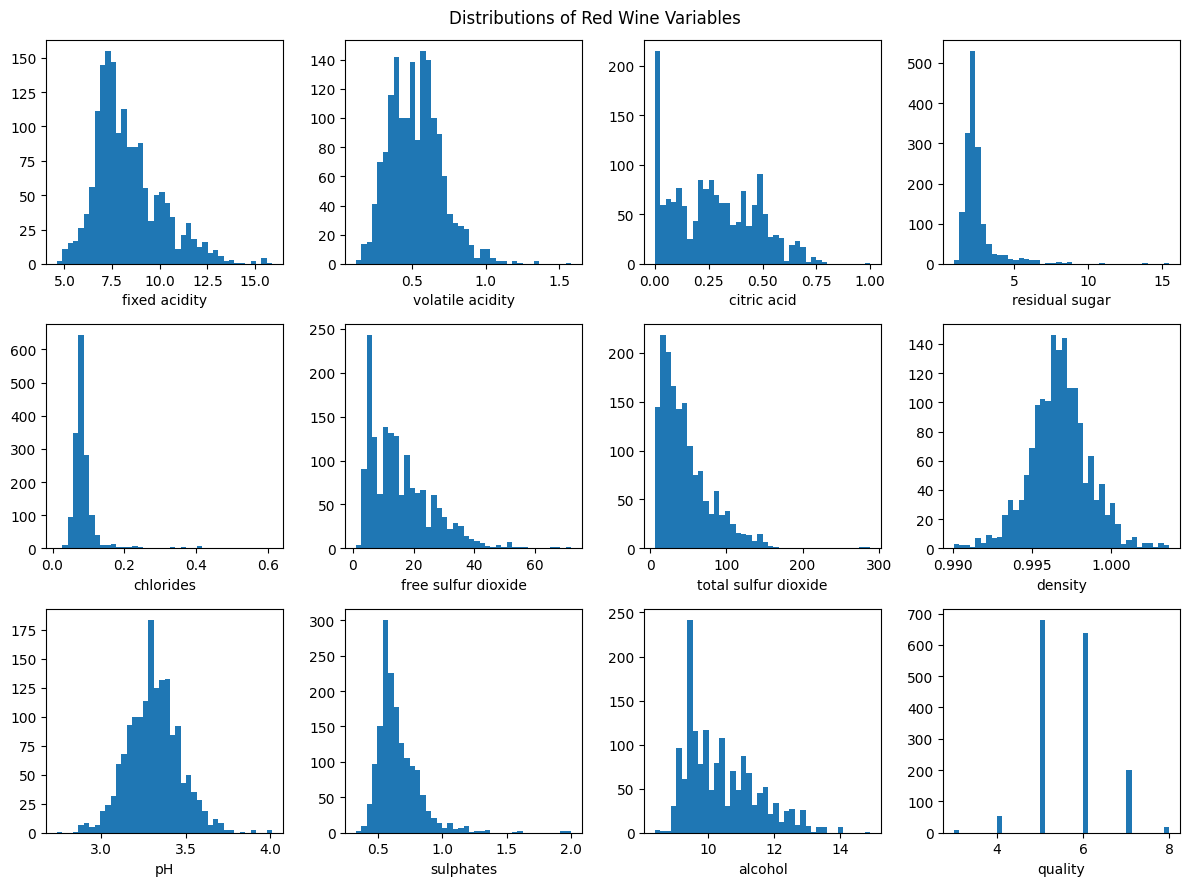

In [23]:
# prepare column names
red_col_names = red_df.columns

fig_red, axs_red = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with distributions
for i in range(12):
    if i < 4:
        axs_red[0][i].hist(red_df[red_col_names[i]], bins=40)
        axs_red[0][i].set_xlabel(red_col_names[i])
    if 4 <= i < 8:
        axs_red[1][i-4].hist(red_df[red_col_names[i]], bins=40)
        axs_red[1][i-4].set_xlabel(red_col_names[i])
    if i >= 8:
        axs_red[2][i-8].hist(red_df[red_col_names[i]], bins=40)
        axs_red[2][i-8].set_xlabel(red_col_names[i])

fig_red.suptitle('Distributions of Red Wine Variables')
fig_red.tight_layout()

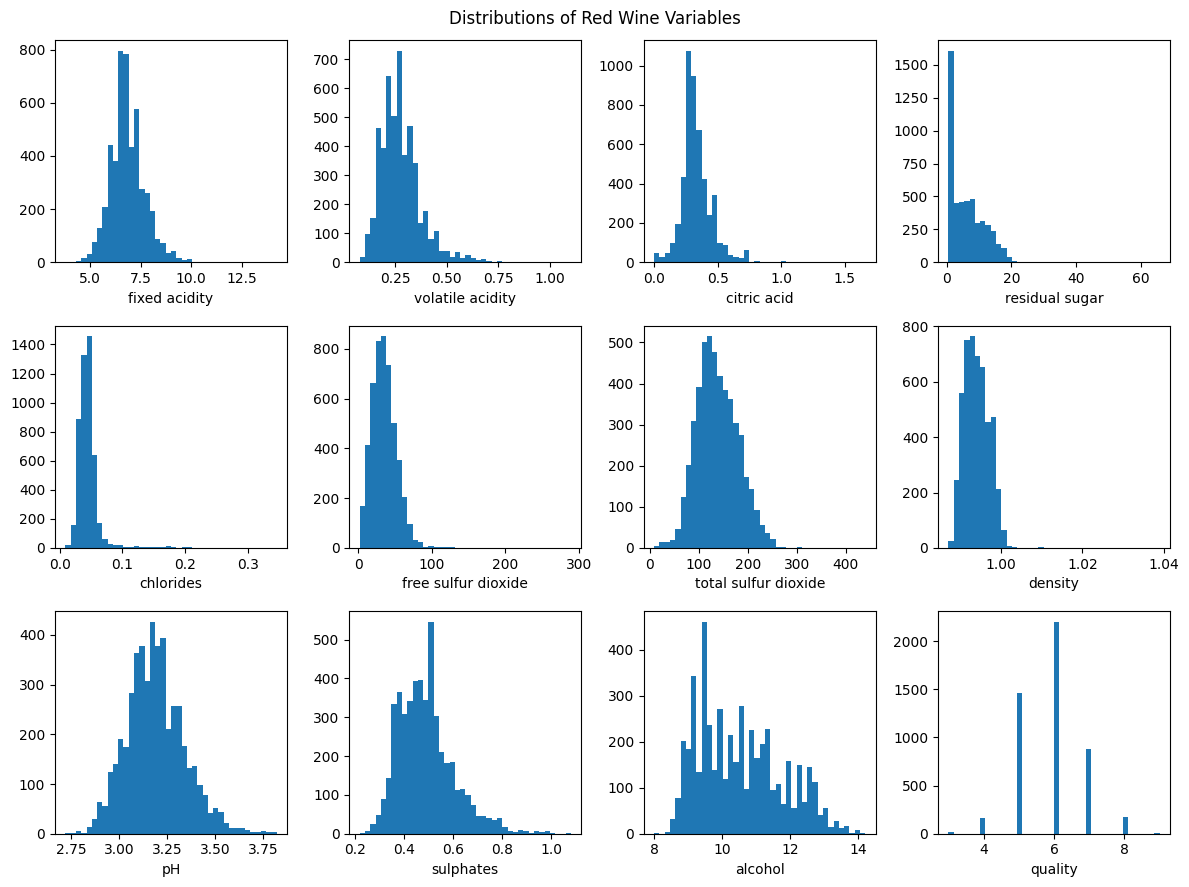

In [24]:
# prepare column names
white_col_names = white_df.columns

fig_white, axs_white = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with distributions
for i in range(12):
    if i < 4:
        axs_white[0][i].hist(white_df[white_col_names[i]], bins=40)
        axs_white[0][i].set_xlabel(white_col_names[i])
    if 4 <= i < 8:
        axs_white[1][i-4].hist(white_df[white_col_names[i]], bins=40)
        axs_white[1][i-4].set_xlabel(white_col_names[i])
    if i >= 8:
        axs_white[2][i-8].hist(white_df[white_col_names[i]], bins=40)
        axs_white[2][i-8].set_xlabel(white_col_names[i])

fig_white.suptitle('Distributions of White Wine Variables')
fig_white.tight_layout()

A few more things become clear from the visualizations:
- The majority of the distributions are right-skewed. Some seem normal, but affected by outliers (like White Wine density and chlorides for both wines).
- Possible outliers have become apparent. There are a significant number of zero-coded values in White Wine residual sugars and Red Wine citric acid. These values require research to determine if zero is a valid value, or an implicit null.
- Density and citric acid are likely percentages (maybe sulphates and chlorides, too). These values require research to determine how they are measured and represented in the data.

Let's break down those zero-code values:
- White Wine residual sugars don't actually have any zero values, per our white_df.describe() above (minimum value is 0.6). A reminder that graphs don't show the whole story!
- [An article on CalWineries](https://www.calwineries.com/learn/wine-chemistry/wine-acids/citric-acid) states "Most, if not all of the citric acid naturally present in the grapes is consumed by bacteria during fermentation... The major disadvantage of adding citric acid is... the citric acid added may just be consumed by bacteria, promoting the growth of unwanted microbes. Because of its microbial instability, winemakers will often use tartaric acid to acidify wines." This presents us with the possibility that Vinho Verde does not add citric acid to all of their wines. However, it seems strange to include it in many wines, and selectively fail to use it on others. For the purposes of the data, these zero-coded values seem valid, given that the citric acid in the wine may be totally consumed by bacteria.

#### Dealing with Outliers

Boxplots will provide us with a better understanding of the outliers. Let's take a look at each feature in boxplot form.

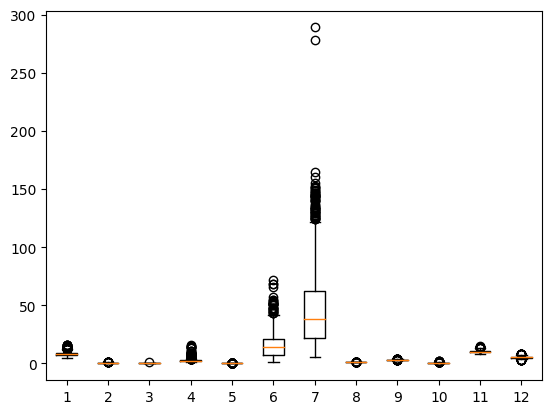

In [26]:
plt.boxplot(red_df)
plt.show()

Oh, right. Maybe having them all on the same scale isn't going to work.
Let's try our 4x3 grid of single plots again.

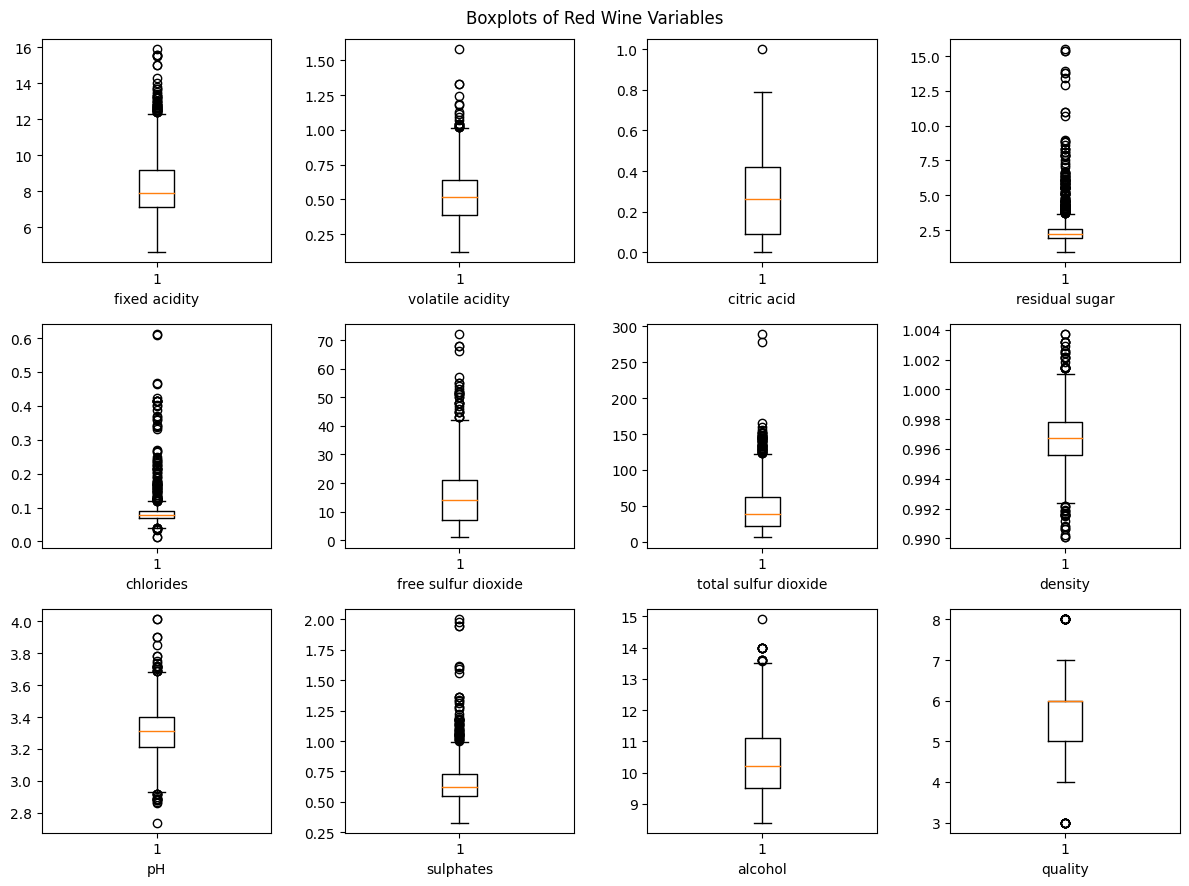

In [27]:
# prepare column names
red_col_names = red_df.columns

fig_red, axs_red = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_red[0][i].boxplot(red_df[red_col_names[i]])
        axs_red[0][i].set_xlabel(red_col_names[i])
    if 4 <= i < 8:
        axs_red[1][i-4].boxplot(red_df[red_col_names[i]])
        axs_red[1][i-4].set_xlabel(red_col_names[i])
    if i >= 8:
        axs_red[2][i-8].boxplot(red_df[red_col_names[i]])
        axs_red[2][i-8].set_xlabel(red_col_names[i])

fig_red.suptitle('Boxplots of Red Wine Variables')
fig_red.tight_layout()

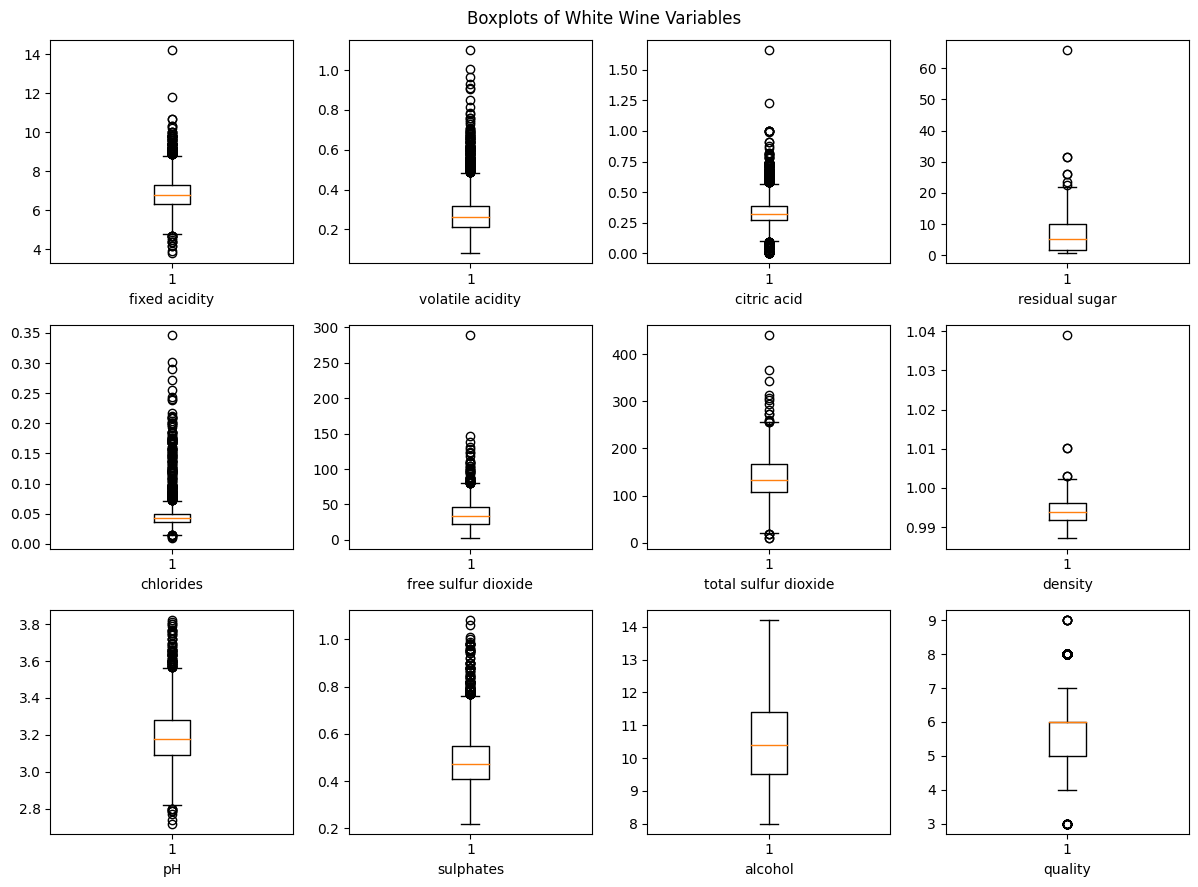

In [29]:
# prepare column names
white_col_names = white_df.columns

fig_white, axs_white = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_white[0][i].boxplot(white_df[white_col_names[i]])
        axs_white[0][i].set_xlabel(white_col_names[i])
    if 4 <= i < 8:
        axs_white[1][i-4].boxplot(white_df[white_col_names[i]])
        axs_white[1][i-4].set_xlabel(white_col_names[i])
    if i >= 8:
        axs_white[2][i-8].boxplot(white_df[white_col_names[i]])
        axs_white[2][i-8].set_xlabel(white_col_names[i])

fig_white.suptitle('Boxplots of White Wine Variables')
fig_white.tight_layout()

Oh dear. Outliers everywhere! This will heavily affect any correlations between the data, and affect outlier-sensitive machine learning algorithms (like linear regression, logistic regression, and PCA).

There are a variety of methods to handle outliers, such as:
1. Deletion: trim outliers from dataset (reduce variance but lose information)
2. Transformation: apply natural log to features with lots of outliers to reduce variation (a good option here)
3. Imputation: impute outliers with mean, median, or mode (not recommended; outliers may not be artificial)
4. Quantile flooring & capping: replace outliers with capped or floored quantile value (eliminate outliers but damages distribution)
5. Whisker stretching: increasing whisker spread, AKA raise IQR multiplier or indicate percentiles (another good option, though may encounter a negative minimum)
6. Separate treatment: treat outliers and non-outliers as two different groups, and build models for each of them (complicated and time consuming)

We probably don't want to delete all rows with outliers considering that our target variable is so imbalanced (the outlier observations might contain the anomalous target values), so we'd best start with a more measured approach.

For Linear Regression, we also have the choice to handle outliers with a Ridge Regression model, which will smooth the impact of the outliers. In the potential case of Logistic Regression, we can substitute a Ridge Classifier. However, neither presents a solution for reducing multicollinearity with PCA.

For the sake of practice, we will create separate dataframes for each dataset, apply Transformation to outlier-rich features, then run correlations to determine feature importance and PCA to determine multicollinearity.

In [33]:
# copy dataframes
red_log_df = red_df.copy()
white_log_df = white_df.copy()

# red wine features with outliers
red_log_features = red_log_df.columns
red_log_features = red_log_features.drop(labels=['citric acid', 'quality'])

# white wine features with outliers
white_log_features = white_log_df.columns
white_log_features = white_log_features.drop(labels=['alcohol', 'quality'])

# apply natural log to selected features
for feature in red_log_features:
    red_log_df[feature] = red_log_df[feature].apply(np.log)
for feature in white_log_features:
    white_log_df[feature] = white_log_df[feature].apply(np.log)

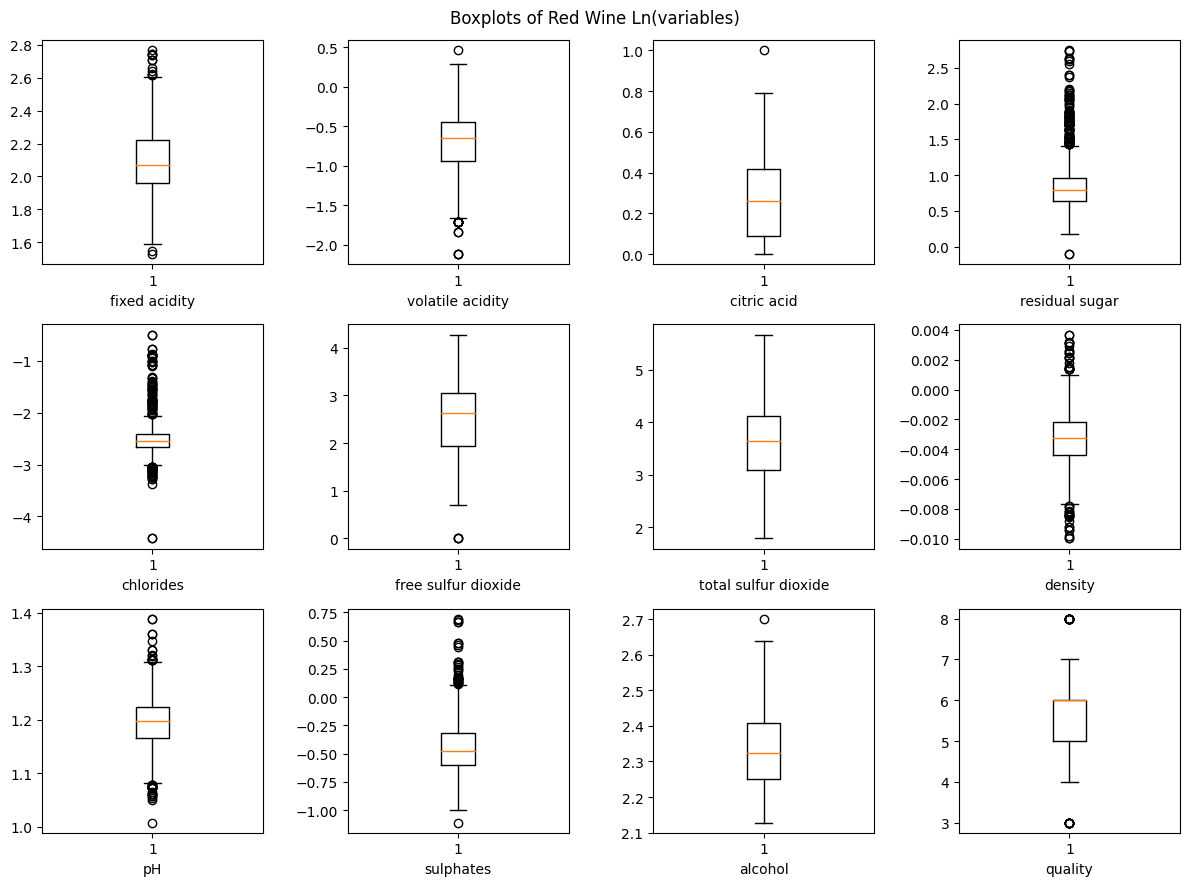

In [34]:
# prepare column names
red_col_names = red_log_df.columns

fig_red, axs_red = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_red[0][i].boxplot(red_log_df[red_col_names[i]])
        axs_red[0][i].set_xlabel(red_col_names[i])
    if 4 <= i < 8:
        axs_red[1][i-4].boxplot(red_log_df[red_col_names[i]])
        axs_red[1][i-4].set_xlabel(red_col_names[i])
    if i >= 8:
        axs_red[2][i-8].boxplot(red_log_df[red_col_names[i]])
        axs_red[2][i-8].set_xlabel(red_col_names[i])

fig_red.suptitle('Boxplots of Red Wine Ln(variables)')
fig_red.tight_layout()

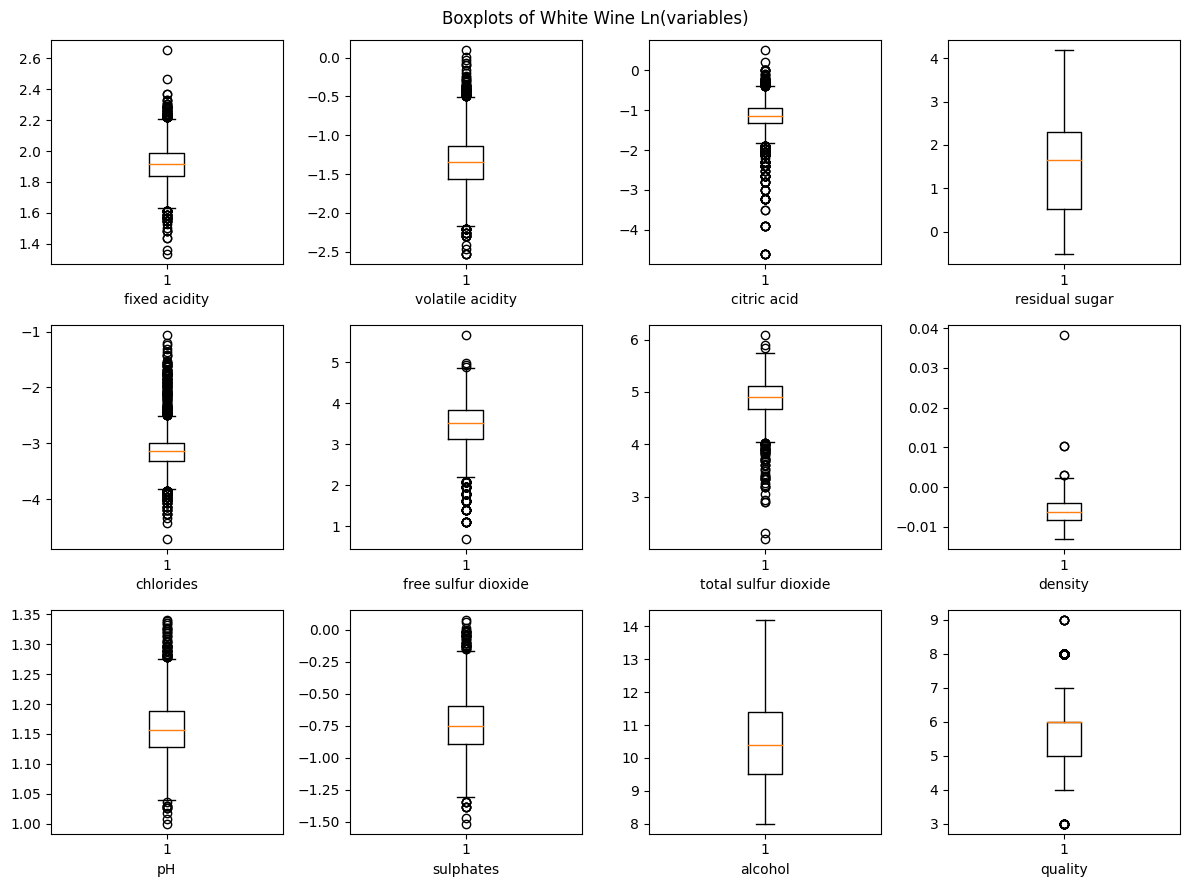

In [35]:
# prepare column names
white_col_names = white_log_df.columns

fig_white, axs_white = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_white[0][i].boxplot(white_log_df[white_col_names[i]])
        axs_white[0][i].set_xlabel(white_col_names[i])
    if 4 <= i < 8:
        axs_white[1][i-4].boxplot(white_log_df[white_col_names[i]])
        axs_white[1][i-4].set_xlabel(white_col_names[i])
    if i >= 8:
        axs_white[2][i-8].boxplot(white_log_df[white_col_names[i]])
        axs_white[2][i-8].set_xlabel(white_col_names[i])

fig_white.suptitle('Boxplots of White Wine Ln(variables)')
fig_white.tight_layout()

Well, some progress was made, though it's not as comprehensive of a solution as we were hoping for. Let's try stretching the whiskers on our original datasets and see what happens.

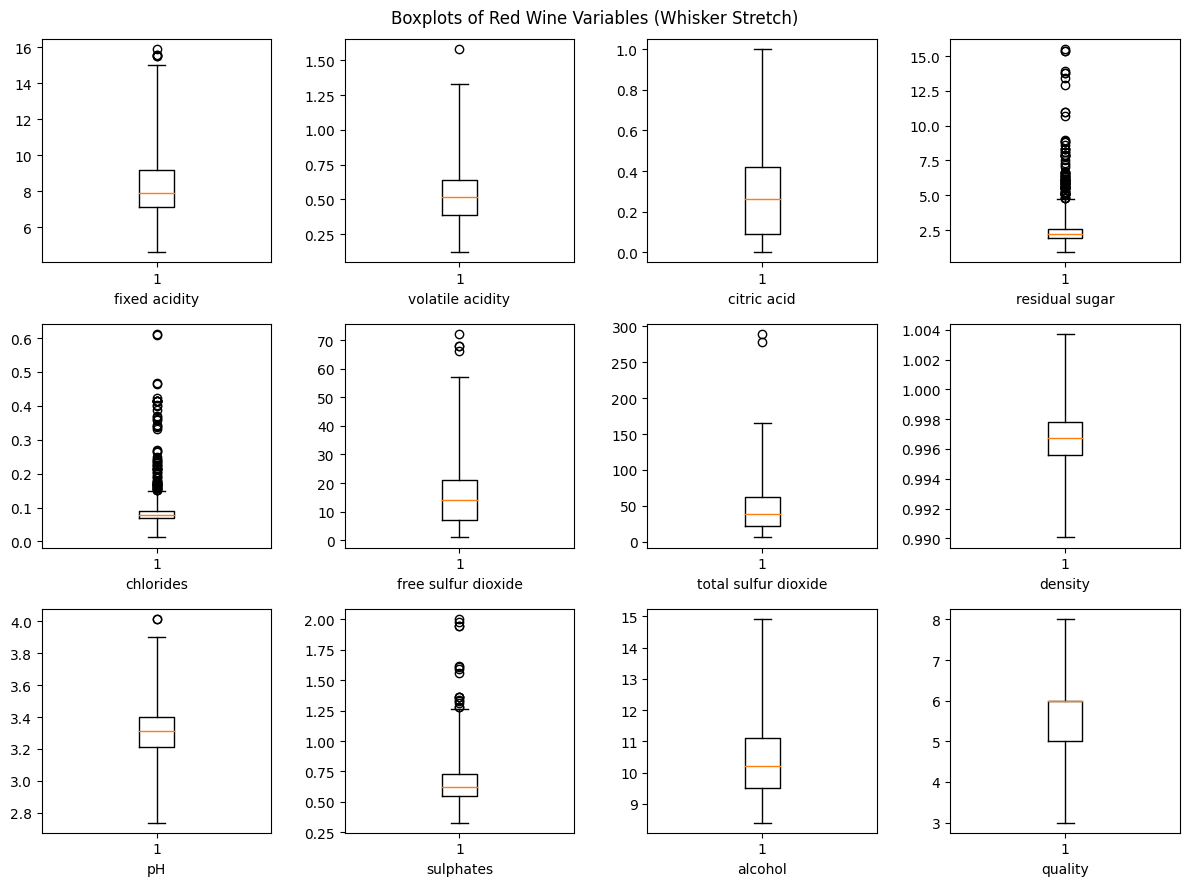

In [36]:
# prepare column names
red_col_names = red_df.columns

fig_red, axs_red = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_red[0][i].boxplot(red_df[red_col_names[i]], whis=3.0)
        axs_red[0][i].set_xlabel(red_col_names[i])
    if 4 <= i < 8:
        axs_red[1][i-4].boxplot(red_df[red_col_names[i]], whis=3.0)
        axs_red[1][i-4].set_xlabel(red_col_names[i])
    if i >= 8:
        axs_red[2][i-8].boxplot(red_df[red_col_names[i]], whis=3.0)
        axs_red[2][i-8].set_xlabel(red_col_names[i])

fig_red.suptitle('Boxplots of Red Wine Variables (Whisker Stretch)')
fig_red.tight_layout()

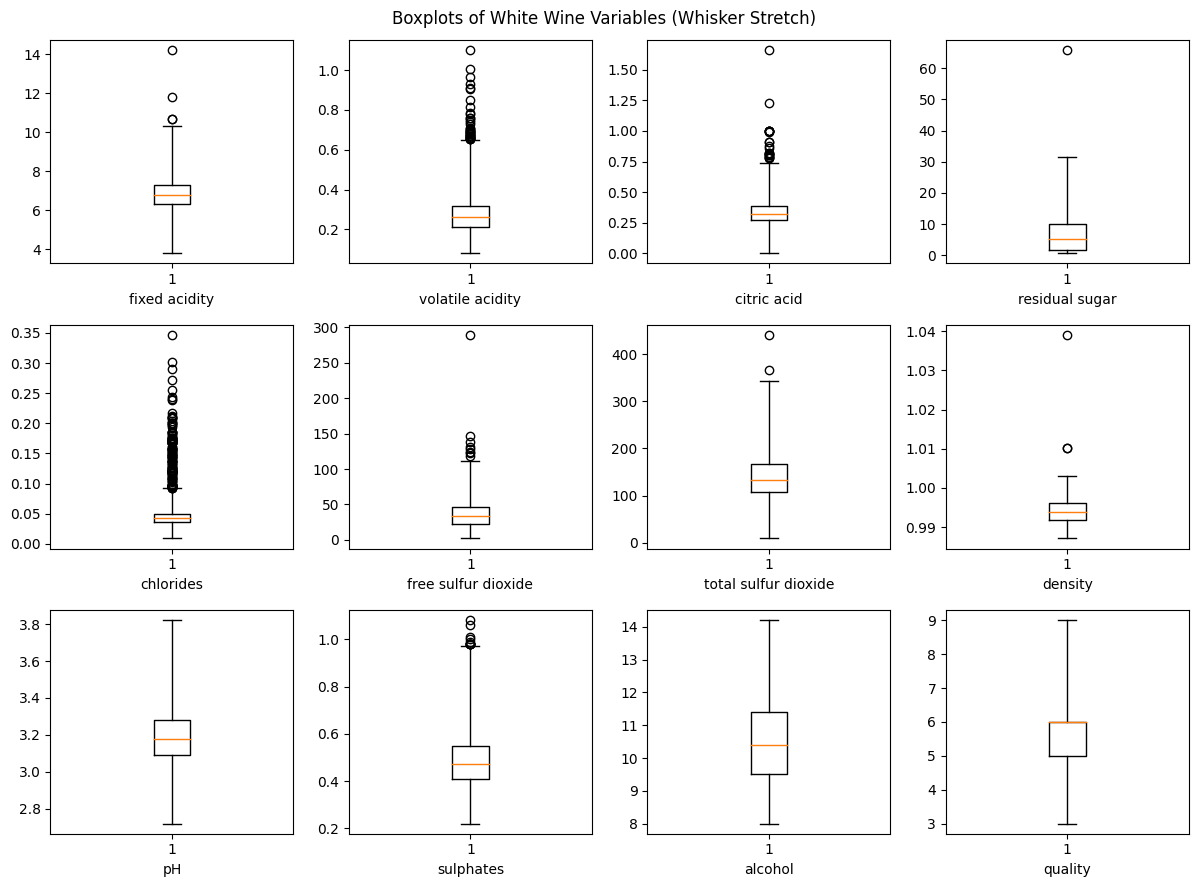

In [37]:
# prepare column names
white_col_names = white_df.columns

fig_white, axs_white = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_white[0][i].boxplot(white_df[white_col_names[i]], whis=3.0)
        axs_white[0][i].set_xlabel(white_col_names[i])
    if 4 <= i < 8:
        axs_white[1][i-4].boxplot(white_df[white_col_names[i]], whis=3.0)
        axs_white[1][i-4].set_xlabel(white_col_names[i])
    if i >= 8:
        axs_white[2][i-8].boxplot(white_df[white_col_names[i]], whis=3.0)
        axs_white[2][i-8].set_xlabel(white_col_names[i])

fig_white.suptitle('Boxplots of White Wine Variables (Whisker Stretch)')
fig_white.tight_layout()

Better, but some features are still struggling. Let's try a whisker stretch, but this time, let's determine the whisker limits by percentile (keep inner 99.5 percent) instead of an IQR multiple.

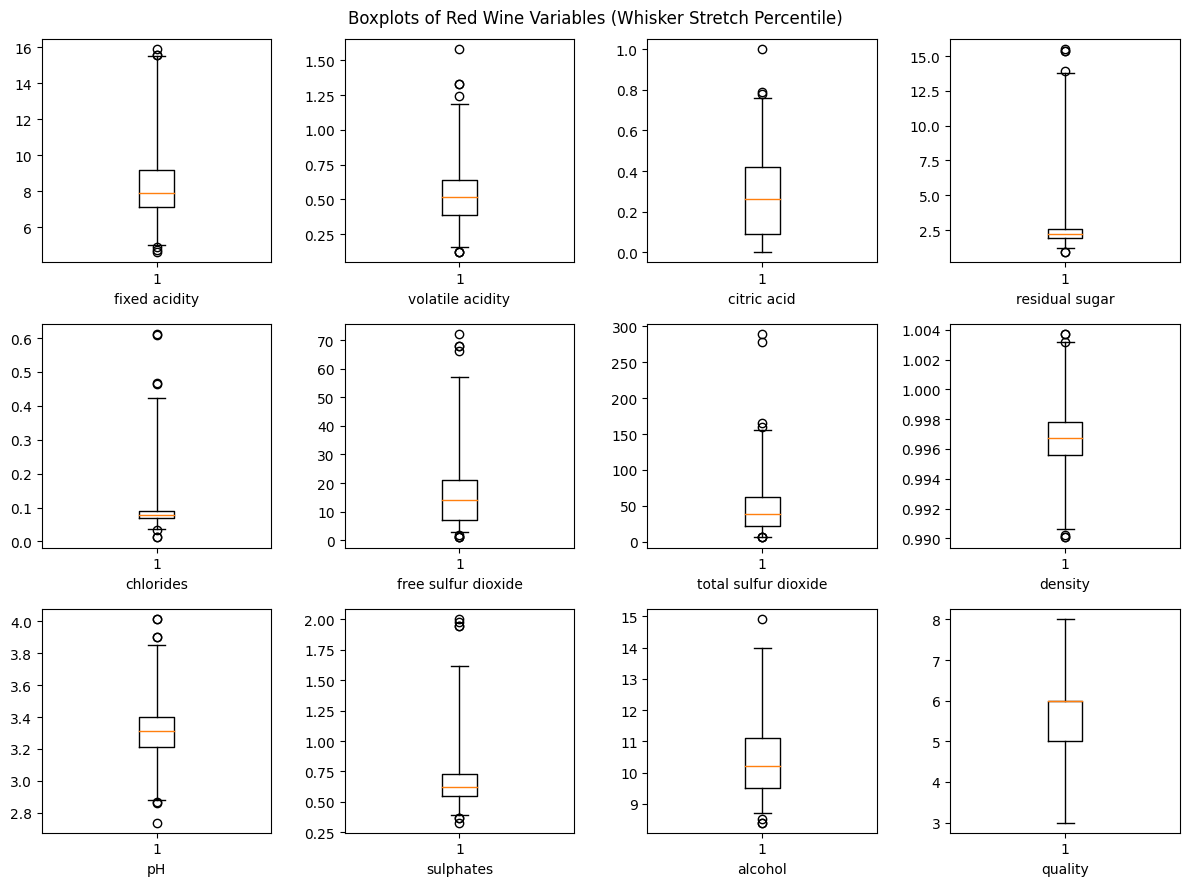

In [41]:
# prepare column names
red_col_names = red_df.columns

fig_red, axs_red = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_red[0][i].boxplot(red_df[red_col_names[i]], whis=(0.25, 99.75))
        axs_red[0][i].set_xlabel(red_col_names[i])
    if 4 <= i < 8:
        axs_red[1][i-4].boxplot(red_df[red_col_names[i]], whis=(0.25, 99.75))
        axs_red[1][i-4].set_xlabel(red_col_names[i])
    if i >= 8:
        axs_red[2][i-8].boxplot(red_df[red_col_names[i]], whis=(0.25, 99.75))
        axs_red[2][i-8].set_xlabel(red_col_names[i])

fig_red.suptitle('Boxplots of Red Wine Variables (Whisker Stretch Percentile)')
fig_red.tight_layout()

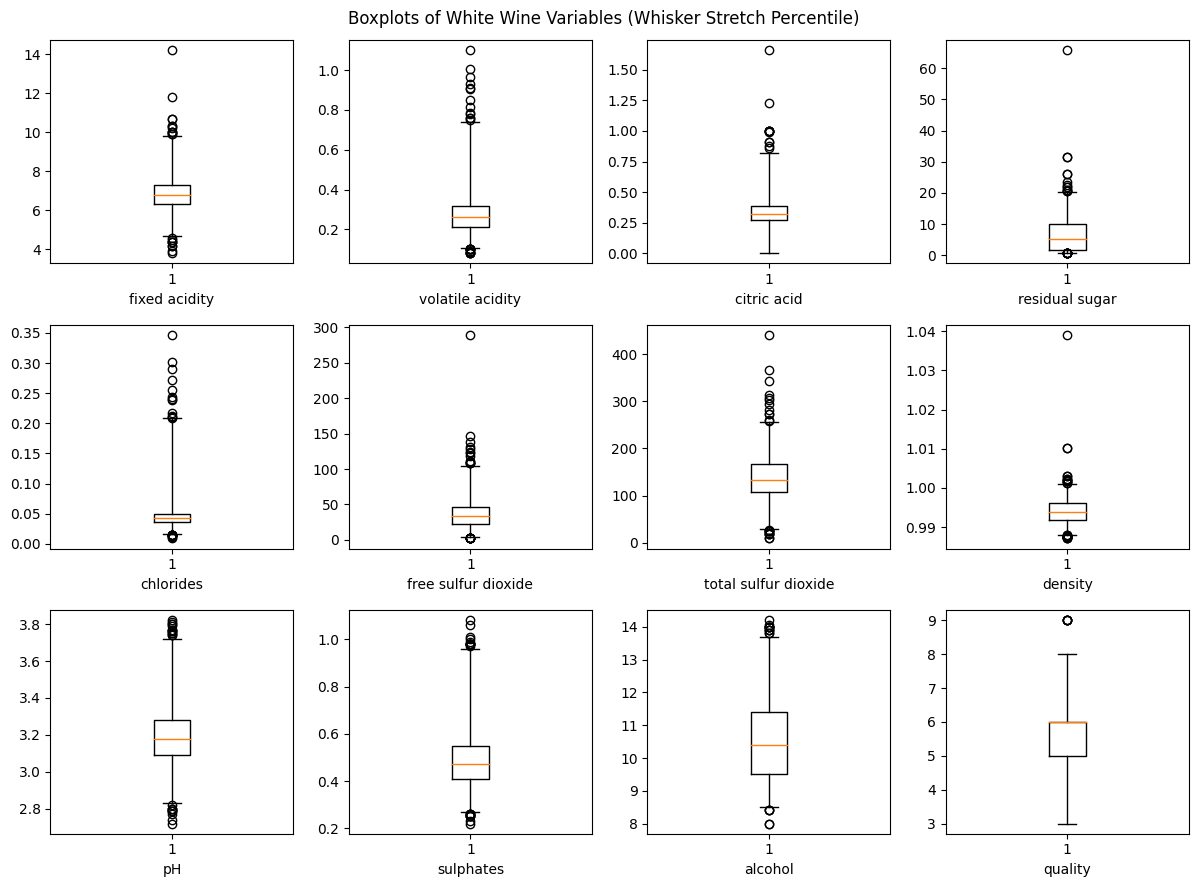

In [42]:
# prepare column names
white_col_names = white_df.columns

fig_white, axs_white = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with boxplots
for i in range(12):
    if i < 4:
        axs_white[0][i].boxplot(white_df[white_col_names[i]], whis=(0.25, 99.75))
        axs_white[0][i].set_xlabel(white_col_names[i])
    if 4 <= i < 8:
        axs_white[1][i-4].boxplot(white_df[white_col_names[i]], whis=(0.25, 99.75))
        axs_white[1][i-4].set_xlabel(white_col_names[i])
    if i >= 8:
        axs_white[2][i-8].boxplot(white_df[white_col_names[i]], whis=(0.25, 99.75))
        axs_white[2][i-8].set_xlabel(white_col_names[i])

fig_white.suptitle('Boxplots of White Wine Variables (Whisker Stretch Percentile)')
fig_white.tight_layout()

A much more manageable set of outliers (at least, it looks that way)! Let's take a look at how our quality distribution is affected by removing these outliers.

In [50]:
# count and ratio of quality values (red wine)
print(red_df['quality'].value_counts().sort_index())
print(red_df['quality'].value_counts(normalize=True).sort_index())

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64
3    0.006254
4    0.033146
5    0.425891
6    0.398999
7    0.124453
8    0.011257
Name: quality, dtype: float64


In [49]:
# count and ratio of quality values (white wine)
print(white_df['quality'].value_counts().sort_index())
print(white_df['quality'].value_counts(normalize=True).sort_index())

3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: quality, dtype: int64
3    0.004083
4    0.033279
5    0.297468
6    0.448755
7    0.179665
8    0.035729
9    0.001021
Name: quality, dtype: float64


In [51]:
# whisker bound functions
def lower_whisker(series):
    return np.percentile(a=series, q=0.25)

def upper_whisker(series):
    return np.percentile(a=series, q=99.75)

In [91]:
# whisker trim dfs
red_whis_trim_df = red_df.copy()
white_whis_trim_df = white_df.copy()

# all features (except target)
red_whis_trim_cols = red_whis_trim_df.columns.drop(labels=['quality'])
white_whis_trim_cols = white_whis_trim_df.columns.drop(labels=['quality'])

# indices to drop
red_index_drop_set = set()
white_index_drop_set = set()

# add trimmed row indices to drop sets
for feature in red_whis_trim_cols:
    red_inds = red_whis_trim_df[feature].loc[
        (red_whis_trim_df[feature] <= lower_whisker(red_whis_trim_df[feature])) |
        (red_whis_trim_df[feature] >= upper_whisker(red_whis_trim_df[feature]))
        ]
    for ind in red_inds.index:
        red_index_drop_set.add(ind)
for feature in white_whis_trim_cols:
    white_inds = white_whis_trim_df[feature].loc[
        (white_whis_trim_df[feature] <= lower_whisker(white_whis_trim_df[feature])) |
        (white_whis_trim_df[feature] >= upper_whisker(white_whis_trim_df[feature]))
        ]
    for ind in white_inds.index:
        white_index_drop_set.add(ind)

# drop rows
red_whis_trim_df = red_whis_trim_df.drop(index=red_index_drop_set)
white_whis_trim_df = white_whis_trim_df.drop(index=white_index_drop_set)

In [92]:
# count and ratio of quality values (red wine, after whisker trim)
print(red_whis_trim_df['quality'].value_counts().sort_index())
print(red_whis_trim_df['quality'].value_counts(normalize=True).sort_index())

3      6
4     38
5    599
6    555
7    179
8     15
Name: quality, dtype: int64
3    0.004310
4    0.027299
5    0.430316
6    0.398707
7    0.128592
8    0.010776
Name: quality, dtype: float64


In [93]:
# count and ratio of quality values (white wine, after whisker trim)
print(white_whis_trim_df['quality'].value_counts().sort_index())
print(white_whis_trim_df['quality'].value_counts(normalize=True).sort_index())

3       8
4     133
5    1370
6    2082
7     832
8     164
9       5
Name: quality, dtype: int64
3    0.001741
4    0.028951
5    0.298215
6    0.453200
7    0.181106
8    0.035699
9    0.001088
Name: quality, dtype: float64


Our efforts were worthwhile! We've removed the most egregious outliers without sacrificing too many anomalous values.

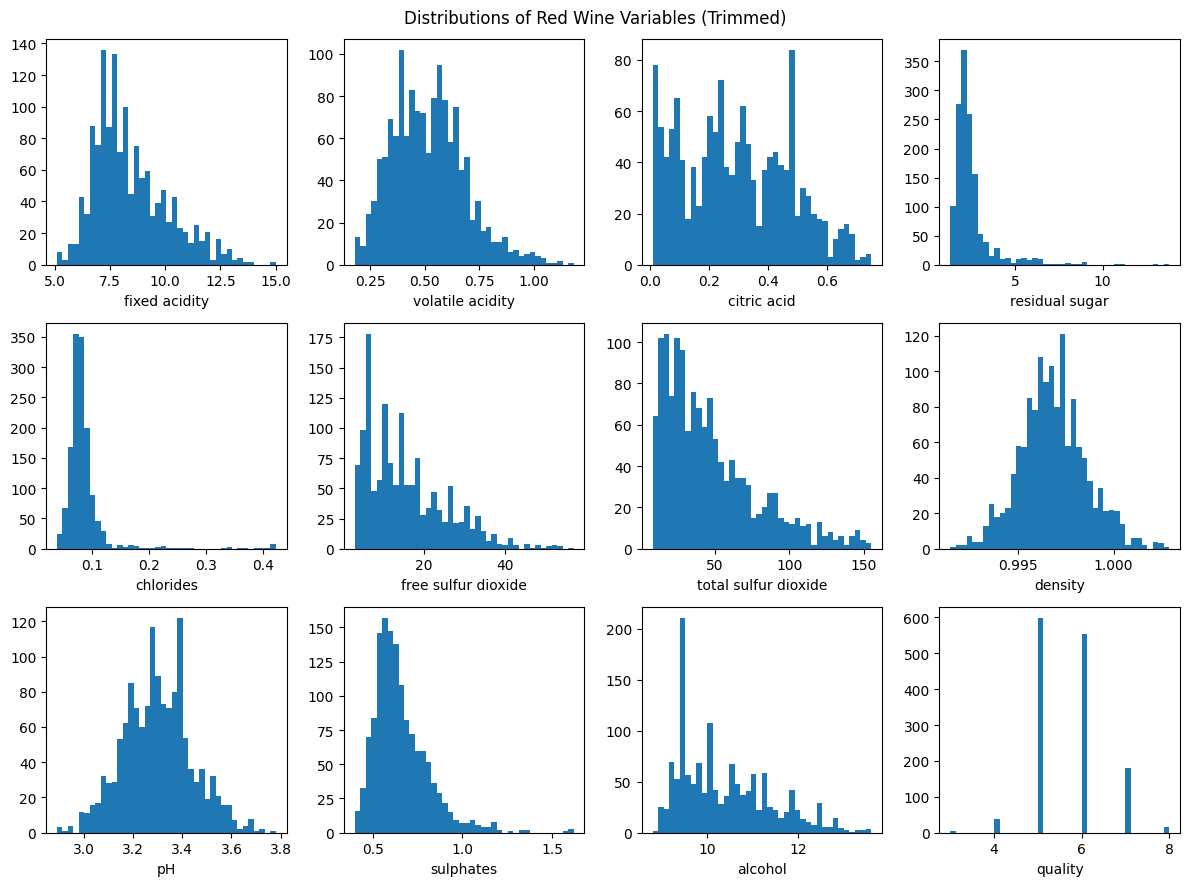

In [94]:
# prepare column names
red_col_names = red_whis_trim_df.columns

fig_red, axs_red = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with distributions
for i in range(12):
    if i < 4:
        axs_red[0][i].hist(red_whis_trim_df[red_col_names[i]], bins=40)
        axs_red[0][i].set_xlabel(red_col_names[i])
    if 4 <= i < 8:
        axs_red[1][i-4].hist(red_whis_trim_df[red_col_names[i]], bins=40)
        axs_red[1][i-4].set_xlabel(red_col_names[i])
    if i >= 8:
        axs_red[2][i-8].hist(red_whis_trim_df[red_col_names[i]], bins=40)
        axs_red[2][i-8].set_xlabel(red_col_names[i])

fig_red.suptitle('Distributions of Red Wine Variables (Trimmed)')
fig_red.tight_layout()

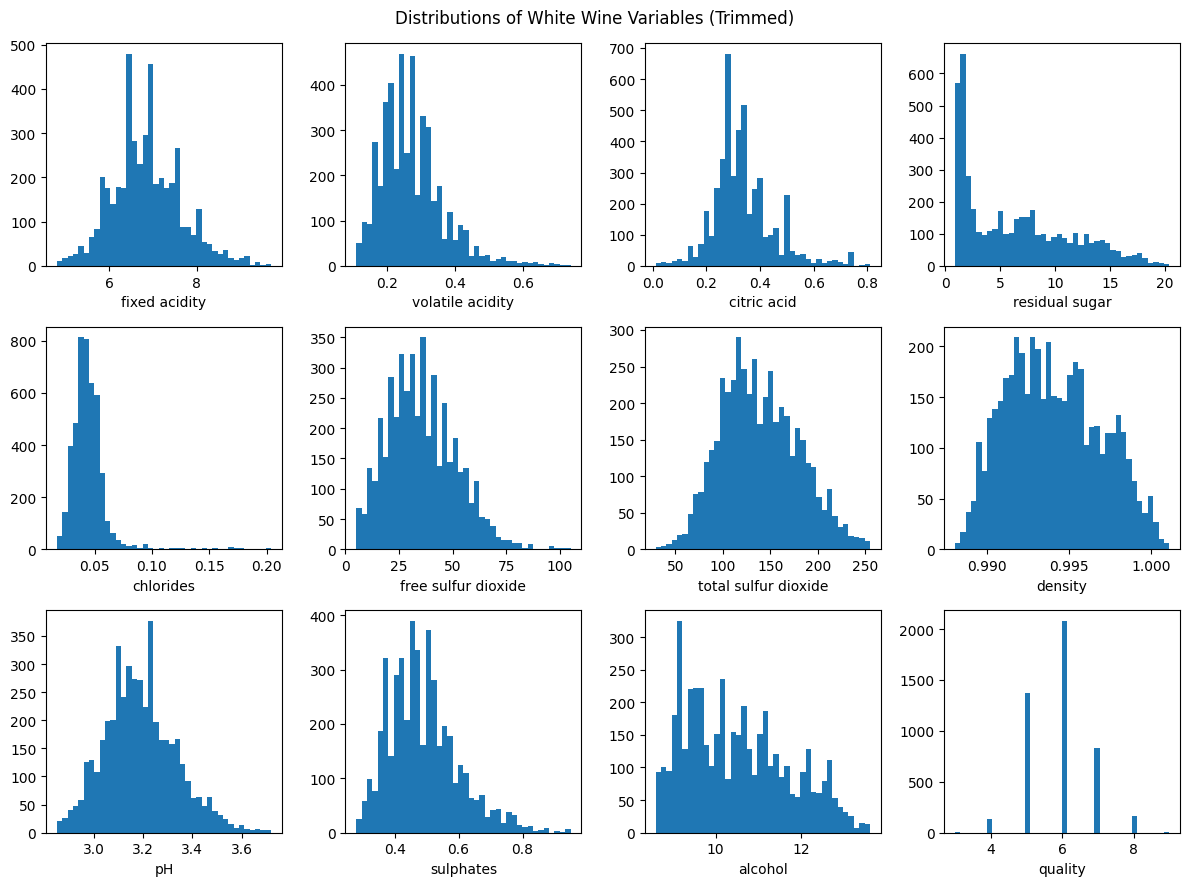

In [95]:
# prepare column names
white_col_names = white_whis_trim_df.columns

fig_white, axs_white = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with distributions
for i in range(12):
    if i < 4:
        axs_white[0][i].hist(white_whis_trim_df[white_col_names[i]], bins=40)
        axs_white[0][i].set_xlabel(white_col_names[i])
    if 4 <= i < 8:
        axs_white[1][i-4].hist(white_whis_trim_df[white_col_names[i]], bins=40)
        axs_white[1][i-4].set_xlabel(white_col_names[i])
    if i >= 8:
        axs_white[2][i-8].hist(white_whis_trim_df[white_col_names[i]], bins=40)
        axs_white[2][i-8].set_xlabel(white_col_names[i])

fig_white.suptitle('Distributions of White Wine Variables (Trimmed)')
fig_white.tight_layout()

The plots are looking much better. We still have some pretty skewed graphs that we could clean up.

Red:
- residual sugar
- chlorides
- sulphates

White:
- volatile acidity
- chlorides

It would be nice to clean these up without damaging our anomalous target values. We do need to be careful about adding outlier cuts on top of each other (the data wrangling gets messy) but we'll give it a try and see if our correlations pay off. Let's create new dataframes for the double-trimmed datasets.

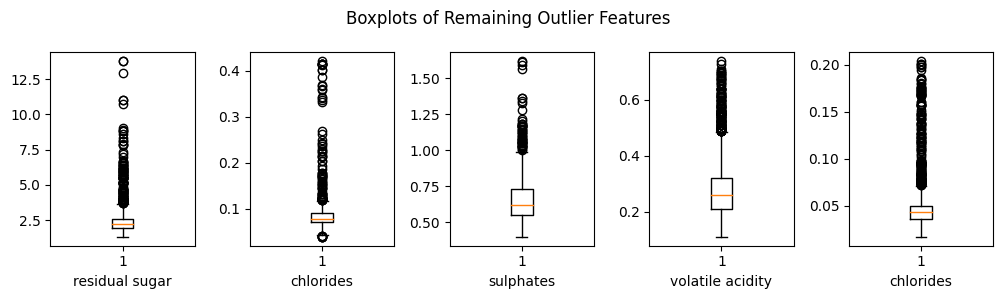

In [99]:
# prepare plots
fig_rw, axs_rw = plt.subplots(1, 5, figsize=(10, 3))

# features with outliers
r_outs = ['residual sugar', 'chlorides', 'sulphates']
w_outs = ['volatile acidity', 'chlorides']

# fill axes with boxplots
for i in range(3):
    axs_rw[i].boxplot(red_whis_trim_df[r_outs[i]])
    axs_rw[i].set_xlabel(r_outs[i])
for i in range(3, 5):
    axs_rw[i].boxplot(white_whis_trim_df[w_outs[i-3]])
    axs_rw[i].set_xlabel(w_outs[i-3])

fig_rw.suptitle('Boxplots of Remaining Outlier Features')
fig_rw.tight_layout()

In [100]:
# standard whisker min & max
def whis_minmax(series):
    q1 = np.percentile(series, q=25.0)
    q3 = np.percentile(series, q=75.0)
    iqr = q3 - q1
    whis_min = q1 - (iqr * 1.5)
    whis_max = q3 + (iqr * 1.5)
    return whis_min, whis_max

In [101]:
# whisker double trim dfs
red_whis_dbl_trim_df = red_whis_trim_df.copy()
white_whis_dbl_trim_df = white_whis_trim_df.copy()

# indices to drop
red_index_drop_set = set()
white_index_drop_set = set()

# add trimmed row indices to drop sets
for feature in r_outs:
    red_lower, red_upper = whis_minmax(red_whis_dbl_trim_df[feature])
    red_inds = red_whis_dbl_trim_df[feature].loc[
        (red_whis_dbl_trim_df[feature] <= red_lower) |
        (red_whis_dbl_trim_df[feature] >= red_upper)
        ]
    for ind in red_inds.index:
        red_index_drop_set.add(ind)
for feature in w_outs:
    white_lower, white_upper = whis_minmax(white_whis_dbl_trim_df[feature])
    white_inds = white_whis_dbl_trim_df[feature].loc[
        (white_whis_dbl_trim_df[feature] <= white_lower) |
        (white_whis_dbl_trim_df[feature] >= white_upper)
        ]
    for ind in white_inds.index:
        white_index_drop_set.add(ind)

# drop rows
red_whis_dbl_trim_df = red_whis_dbl_trim_df.drop(index=red_index_drop_set)
white_whis_dbl_trim_df = white_whis_dbl_trim_df.drop(index=white_index_drop_set)

In [102]:
# count and ratio of quality values (red wine, after double whisker trim)
print(red_whis_dbl_trim_df['quality'].value_counts().sort_index())
print(red_whis_dbl_trim_df['quality'].value_counts(normalize=True).sort_index())

3      4
4     26
5    513
6    472
7    138
8     12
Name: quality, dtype: int64
3    0.003433
4    0.022318
5    0.440343
6    0.405150
7    0.118455
8    0.010300
Name: quality, dtype: float64


In [103]:
# count and ratio of quality values (white wine, after double whisker trim)
print(white_whis_dbl_trim_df['quality'].value_counts().sort_index())
print(white_whis_dbl_trim_df['quality'].value_counts(normalize=True).sort_index())

3       7
4     103
5    1229
6    1974
7     819
8     154
9       5
Name: quality, dtype: int64
3    0.001631
4    0.024004
5    0.286413
6    0.460033
7    0.190865
8    0.035889
9    0.001165
Name: quality, dtype: float64


We lost most of our 3-rated observations in the outlier trimming, but at least we still have values for them! Let's take one final look at our distributions.

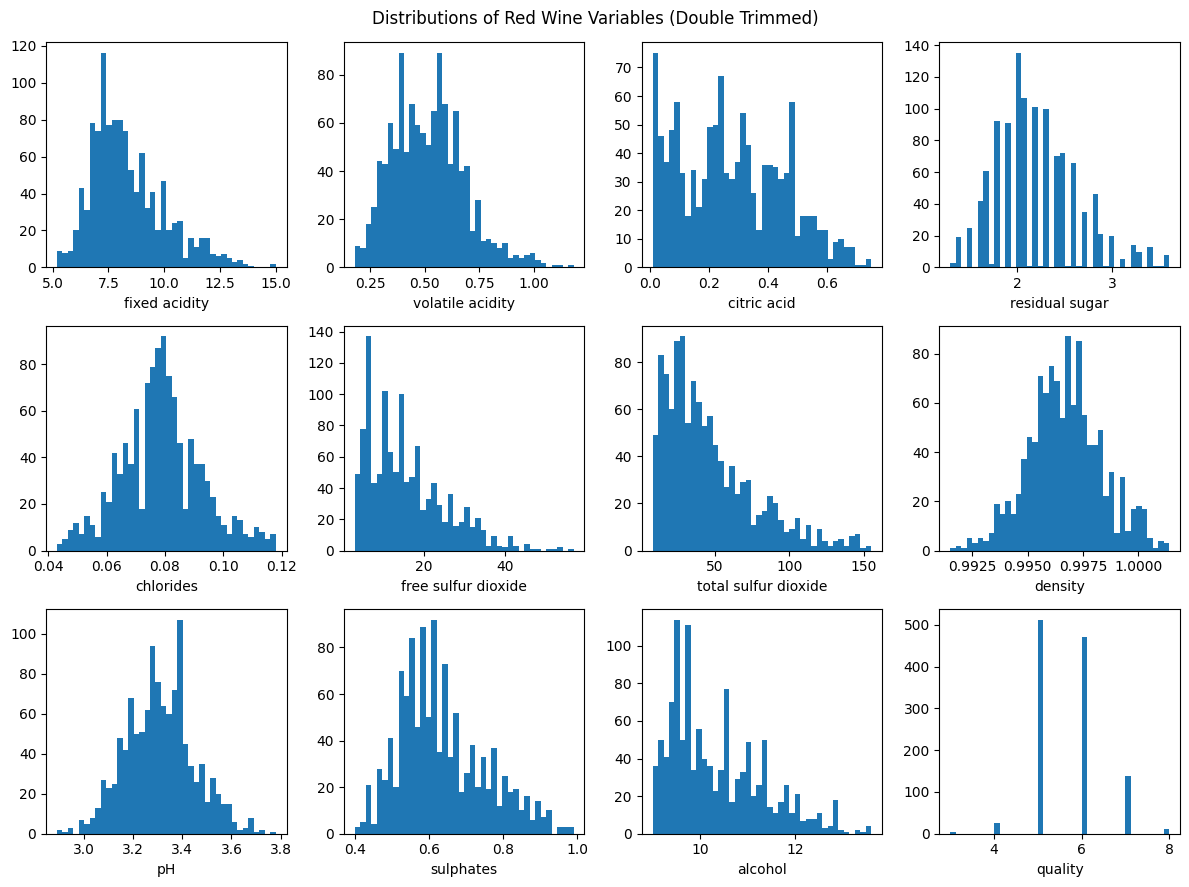

In [104]:
# prepare column names
red_col_names = red_whis_dbl_trim_df.columns

fig_red, axs_red = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with distributions
for i in range(12):
    if i < 4:
        axs_red[0][i].hist(red_whis_dbl_trim_df[red_col_names[i]], bins=40)
        axs_red[0][i].set_xlabel(red_col_names[i])
    if 4 <= i < 8:
        axs_red[1][i-4].hist(red_whis_dbl_trim_df[red_col_names[i]], bins=40)
        axs_red[1][i-4].set_xlabel(red_col_names[i])
    if i >= 8:
        axs_red[2][i-8].hist(red_whis_dbl_trim_df[red_col_names[i]], bins=40)
        axs_red[2][i-8].set_xlabel(red_col_names[i])

fig_red.suptitle('Distributions of Red Wine Variables (Double Trimmed)')
fig_red.tight_layout()

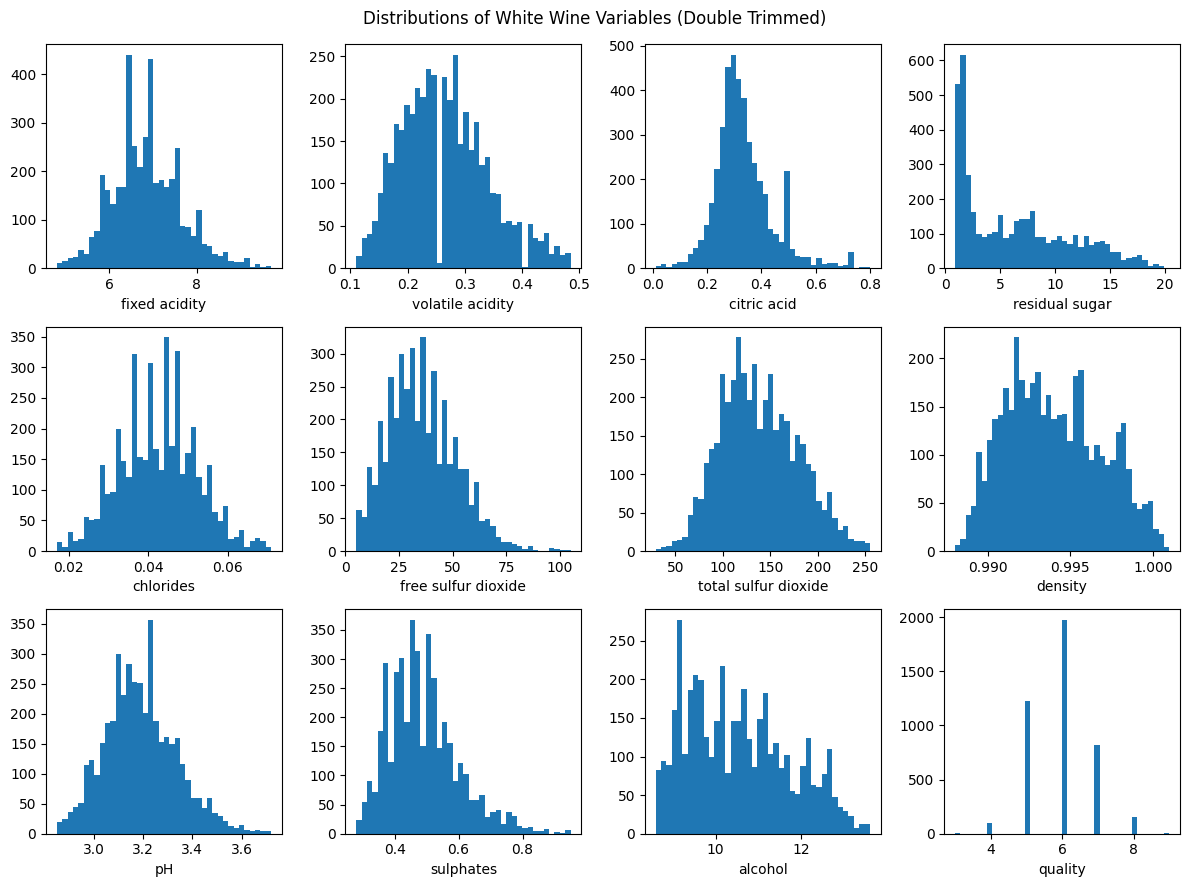

In [105]:
# prepare column names
white_col_names = white_whis_dbl_trim_df.columns

fig_white, axs_white = plt.subplots(3, 4, figsize=(12, 9))

# fill axes with distributions
for i in range(12):
    if i < 4:
        axs_white[0][i].hist(white_whis_dbl_trim_df[white_col_names[i]], bins=40)
        axs_white[0][i].set_xlabel(white_col_names[i])
    if 4 <= i < 8:
        axs_white[1][i-4].hist(white_whis_dbl_trim_df[white_col_names[i]], bins=40)
        axs_white[1][i-4].set_xlabel(white_col_names[i])
    if i >= 8:
        axs_white[2][i-8].hist(white_whis_dbl_trim_df[white_col_names[i]], bins=40)
        axs_white[2][i-8].set_xlabel(white_col_names[i])

fig_white.suptitle('Distributions of White Wine Variables (Double Trimmed)')
fig_white.tight_layout()

Everything looks so much more normal! Still not perfect, but loads better than it was when we started.

### Correlations & PCA

Now that our distributions are less outlier-rich, let's look at how our variables correlate to the target variable, and to each other. Then we'll perform PCA on the features as a second opinion on feature importance and multicollinearity.

In [107]:
red_whis_dbl_trim_df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.243420,0.686913,0.265681,0.183660,-0.136354,-0.102577,0.667932,-0.692484,0.184345,-0.062577,0.115394
volatile acidity,-0.243420,1.000000,-0.560694,0.032466,0.105335,-0.028341,0.138692,0.025820,0.186190,-0.341553,-0.195561,-0.370881
citric acid,0.686913,-0.560694,1.000000,0.170910,0.111292,-0.060423,-0.027468,0.377336,-0.495989,0.267091,0.112217,0.212014
residual sugar,0.265681,0.032466,0.170910,1.000000,0.210809,0.058978,0.145567,0.416185,-0.071657,0.064648,0.099140,0.020656
chlorides,0.183660,0.105335,0.111292,0.210809,1.000000,0.010343,0.182061,0.395013,-0.186277,-0.076569,-0.297266,-0.198242
free sulfur dioxide,-0.136354,-0.028341,-0.060423,0.058978,0.010343,1.000000,0.642956,-0.039999,0.124576,0.075347,-0.027065,-0.020544
total sulfur dioxide,-0.102577,0.138692,-0.027468,0.145567,0.182061,0.642956,1.000000,0.106131,-0.003701,-0.122132,-0.263062,-0.247000
density,0.667932,0.025820,0.377336,0.416185,0.395013,-0.039999,0.106131,1.000000,-0.288063,0.077027,-0.512698,-0.212252
pH,-0.692484,0.186190,-0.495989,-0.071657,-0.186277,0.124576,-0.003701,-0.288063,1.000000,0.004657,0.156657,-0.057759
sulphates,0.184345,-0.341553,0.267091,0.064648,-0.076569,0.075347,-0.122132,0.077027,0.004657,1.000000,0.292806,0.426918


In [108]:
white_whis_dbl_trim_df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.042287,0.284730,0.067888,0.090036,-0.032288,0.090334,0.252783,-0.391527,-0.010767,-0.112600,-0.090435
volatile acidity,-0.042287,1.000000,-0.112526,0.058968,-0.035412,-0.060758,0.110372,-0.015873,-0.057718,-0.053824,0.090947,-0.136357
citric acid,0.284730,-0.112526,1.000000,0.090218,0.037348,0.099435,0.118726,0.150026,-0.130420,0.085071,-0.076938,-0.034763
residual sugar,0.067888,0.058968,0.090218,1.000000,0.271105,0.340678,0.409478,0.842853,-0.201216,-0.040955,-0.501077,-0.123219
chlorides,0.090036,-0.035412,0.037348,0.271105,1.000000,0.155143,0.359336,0.489867,-0.019992,0.063025,-0.543528,-0.284552
free sulfur dioxide,-0.032288,-0.060758,0.099435,0.340678,0.155143,1.000000,0.609590,0.333268,-0.018539,0.060362,-0.267145,0.006697
total sulfur dioxide,0.090334,0.110372,0.118726,0.409478,0.359336,0.609590,1.000000,0.546346,-0.008616,0.116244,-0.473667,-0.185970
density,0.252783,-0.015873,0.150026,0.842853,0.489867,0.333268,0.546346,1.000000,-0.084756,0.075279,-0.819867,-0.317489
pH,-0.391527,-0.057718,-0.130420,-0.201216,-0.019992,-0.018539,-0.008616,-0.084756,1.000000,0.159990,0.107905,0.093607
sulphates,-0.010767,-0.053824,0.085071,-0.040955,0.063025,0.060362,0.116244,0.075279,0.159990,1.000000,-0.042014,0.039568


It's tough to see what's going on through all the numbers. Let's make a heatmap!

<AxesSubplot: >

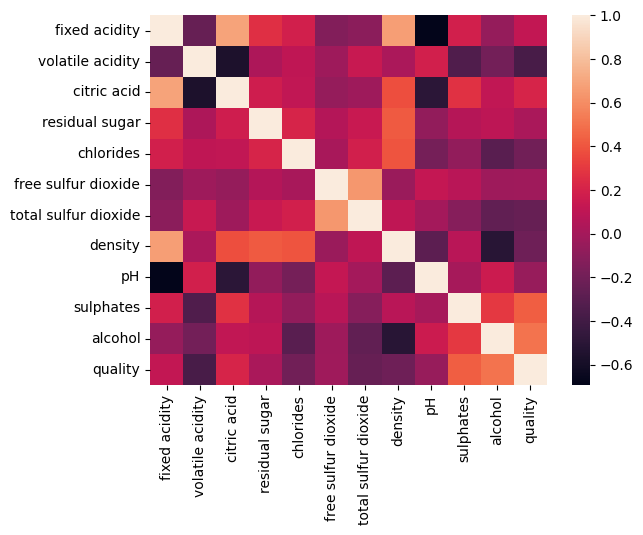

In [109]:
sns.heatmap(red_whis_dbl_trim_df.corr())

<AxesSubplot: >

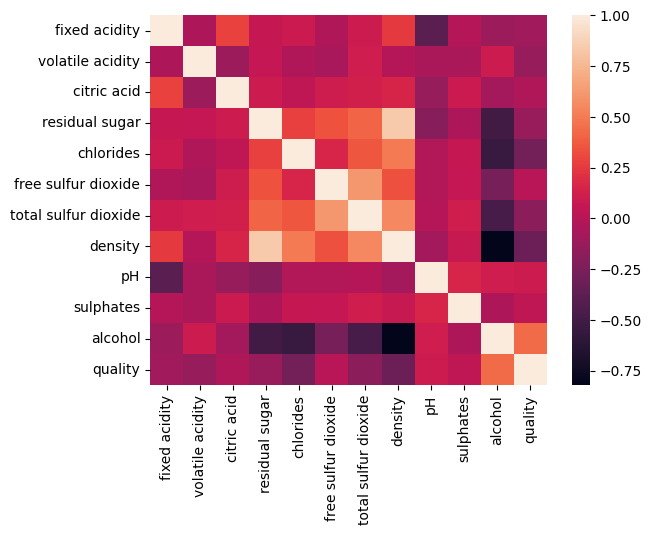

In [110]:
sns.heatmap(white_whis_dbl_trim_df.corr())

The colors are quite messy, we don't have any numbers, and the top half of the graph is redundant!  

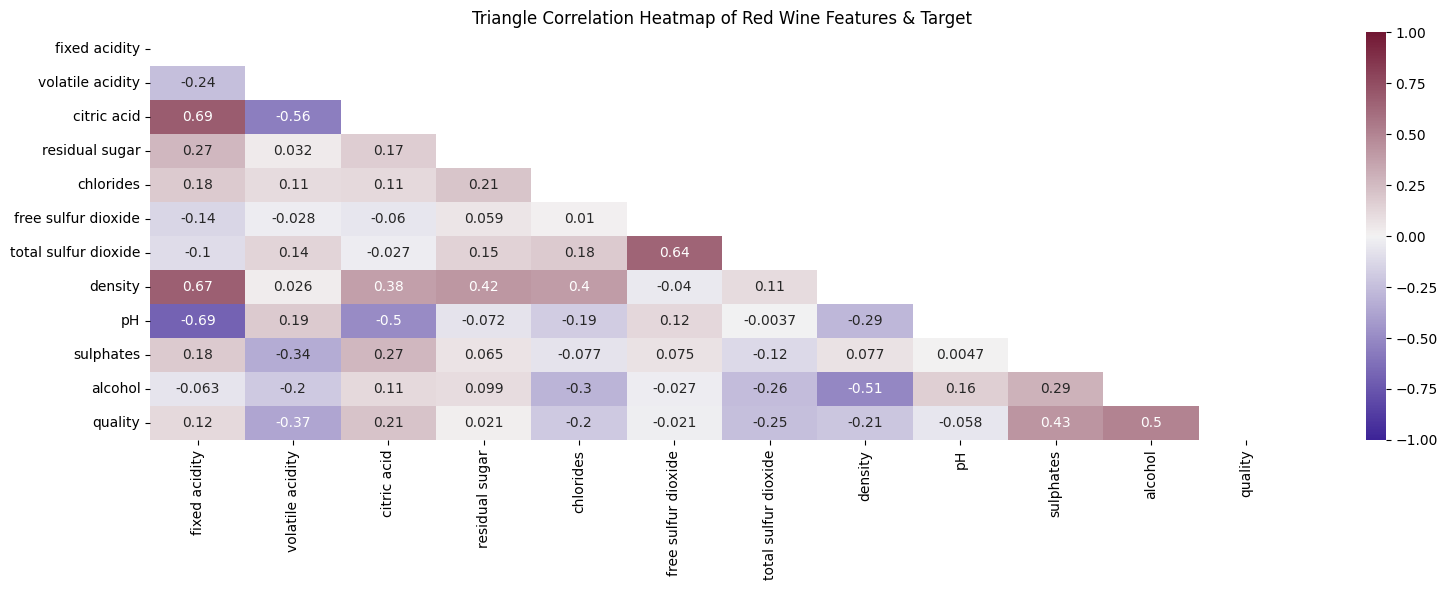

In [115]:
fig = plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(red_whis_dbl_trim_df.corr()))

heatmap = sns.heatmap(red_whis_dbl_trim_df.corr(),
                    mask=mask,
                    vmin=-1, vmax=1,
                    annot=True,
                    cmap=sns.diverging_palette(270, 0, s=80, l=25, as_cmap=True))

heatmap.set_title('Triangle Correlation Heatmap of Red Wine Features & Target')

fig.tight_layout()


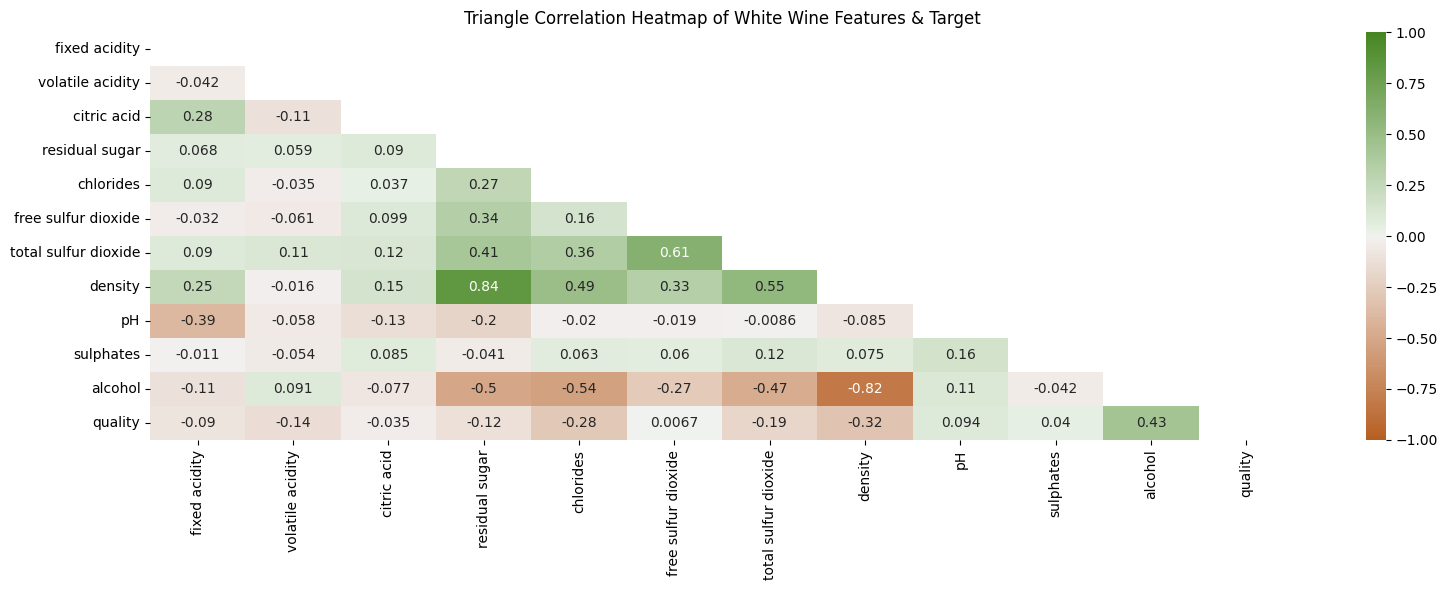

In [117]:
fig = plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(white_whis_dbl_trim_df.corr()))

heatmap = sns.heatmap(white_whis_dbl_trim_df.corr(),
                    mask=mask,
                    vmin=-1, vmax=1,
                    annot=True,
                    cmap=sns.diverging_palette(30, 120, s=90, l=50, as_cmap=True))

heatmap.set_title('Triangle Correlation Heatmap of White Wine Features & Target')

fig.tight_layout()

Much better. Now we can get to know our correlation values!

For red wine:
- total sulfur oxide vs free sulfur oxide: strong positive
- fixed acidity vs density: strong postive
- fixed acidity vs citric acid: strong postive
- volatile acidity vs citric acid: moderate negative
- pH vs citric acid: moderate negative
- alcohol vs density: moderate negative
- fixed acidity vs pH: strong negative
- strongest with target(quality): alcohol(mp), sulphates(mp), volatile acidity(mn)

For white wine:
- density vs residual sugar: strong positive
- total sulfur oxide vs free sulfur oxide: strong positive
- total sulfur oxide vs density: moderate positive
- density vs chlorides: moderate positive
- total sulfur oxide vs residual sugar: moderate positive
- pH vs fixed acidity: moderate negative
- alcohol vs total sulfur dioxide: moderate negative
- alcohol vs residual sugar: moderate negative
- alcohol vs chlorides: moderate negative
- alcohol vs density: strong negative
- strongest with target(quality): alcohol(mp), density(wn), chlorides(wn)

That's a lot of info. Let's unpack this.

Or maybe not. (Sudden shift to first person!) I've put some thought into how I want to approach this, and honestly, I have no idea what I'm doing. It's getting so messy and complicated, and that's code for "there's an easier way". So I'm going to take a step back and try to remember why I'm doing all of this to begin with.

As far as multicollinearity goes, I could try variance inflation factor (VIF) which I've never tried before, but it seems like it could be more useful than just looking at a triangle of correlations.

What I'm more interested in is how to preserve the anomalous target values for use in our machine learning model. I have to do some research on anomaly detection machines, and working with imbalanced datasets.

## First Iteration Summary & Insights

### Summary

In the first iteration, we:
1. Explored the distributions of our data and found a swarm of outliers
2. Attempted to normalize the features by removing outliers, while keeping as many anomalous target value observations as possible
3. Viewed correlations between the features

### Insights

Let's reframe the objectives for this notebook.

I wanted to try out PCA on this analysis, which is why I was so focused on smoothing out the distributions and preparing the data for correlation analysis. But given that we're doing all this work to fit (more than one?) machine learning algorithms, we probably shouldn't be going through hassle if it's unnecessary.

For the rest of the notebook, let's stick to a more iterative approach: Fit the data as is, see what comes out of it, and make small adjustments as necessary to increase the accuracy of my models. While this approach is less "explorative", I'm not sure the "explorative" approach is going to provide more benefit, so let's keep to the scope and objectives of the project, which we're going to redefine.

## Redefining Objective

The overall goal: Create an accurate machine learning algorithm for predicing wine quality.

### Notes on the New Approach

I can choose either regression or classification for this. I'm split on which I should choose. The fact that the target values are discrete gives me reason to choose classification, but because the values are ordinal, I can also work with regression (and, should the regression outputs be continuous, find some way to convert them to the discrete target values). I expect to try them both and see which one works better.

Since I'm working with an imbalanced dataset, I won't be using simple accuracy as a performance metric. I will most likely choose some method that operates like a confusion matrix. Perhaps F1-score, or ROC/AUC.

I've looked into some methods for how to better balance the data. Given that I'm not working with a whole lot of data (several thousand points for each set), I expect that I'll be generating synthetic samples for the anomaly classes. I'll look into that later.

## Second Iteration

Let's start over with a fresh pull of the data. For now, even though the dataset is imbalanced, there are a ton of outliers, and I'm not sure how the features contribute to (or detract from) my model's performance, at least the data we have is in a clean format. Let's fit some models and see what happens.

### Getting the Data

We already have our data in white_df and red_df, but just to make sure we haven't altered it in our previous steps, let's reload it (and so we don't have to run any code from the first iteration).

In [2]:
# loading datasets
red_df = pd.read_csv('winequality-red.csv', delimiter=';')
white_df = pd.read_csv('winequality-white.csv', delimiter=';')
print(red_df.shape)
print(white_df.shape)

(1599, 12)
(4898, 12)


In [3]:
red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### EDA 1

We've already done a lot of EDA, but let's take a look at our distributions again, just to have it nearby.

Also, there was a lot of copy-paste in the first iteration. Let's make our distributions a little more reusable with a function.

In [5]:
# graphs variable distributions
def graph_distributions(df, wine_type=""):

    # prepare column names
    df_cols = df.columns

    fig, axs = plt.subplots(3, 4, figsize=(8, 6))

    # fill axes with distributions
    for i in range(12):
        if i < 4:
            axs[0][i].hist(df[df_cols[i]], bins=40)
            axs[0][i].set_xlabel(df_cols[i])
        if 4 <= i < 8:
            axs[1][i-4].hist(df[df_cols[i]], bins=40)
            axs[1][i-4].set_xlabel(df_cols[i])
        if i >= 8:
            axs[2][i-8].hist(df[df_cols[i]], bins=40)
            axs[2][i-8].set_xlabel(df_cols[i])

    fig.suptitle(f'Distributions of {wine_type} Wine Features')

    return fig.tight_layout()

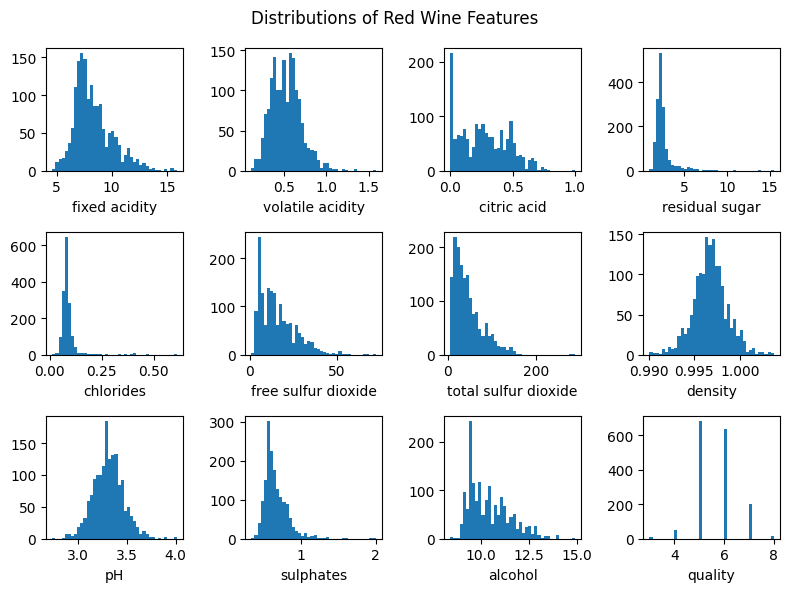

In [6]:
graph_distributions(red_df, "Red")

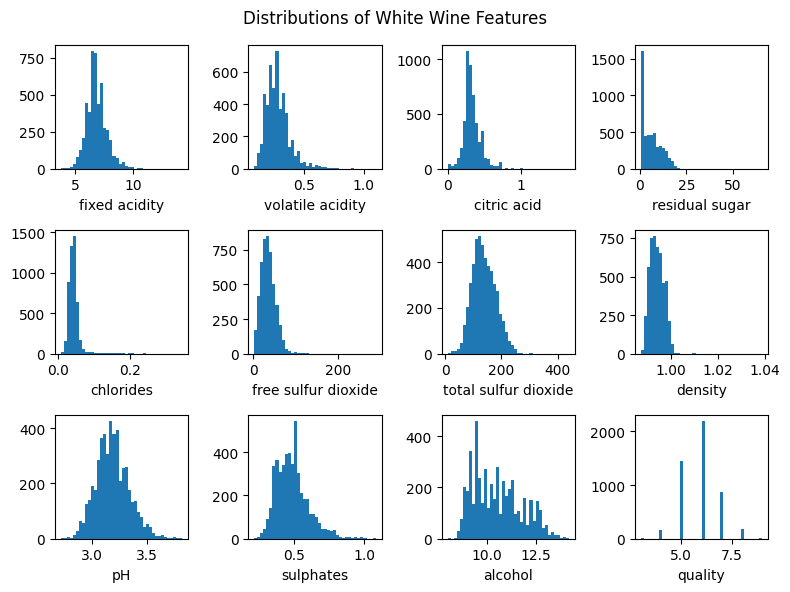

In [7]:
graph_distributions(white_df, "White")

### Train & Test Sets

Now we need to split our data into training and testing sets. The problem we face with a blind (randomized) split is that we are unlikely to have observations in our test set that include anomalous quality values. Let's take a look at our value counts for quality in both sets.

In [8]:
print(red_df['quality'].value_counts().sort_index())
print(red_df['quality'].value_counts(ascending=True, normalize=True).sort_index() * 100)

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64
3     0.625391
4     3.314572
5    42.589118
6    39.899937
7    12.445278
8     1.125704
Name: quality, dtype: float64


In [9]:
print(white_df['quality'].value_counts().sort_index())
print(white_df['quality'].value_counts(ascending=True, normalize=True).sort_index() * 100)

3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: quality, dtype: int64
3     0.408330
4     3.327889
5    29.746835
6    44.875459
7    17.966517
8     3.572887
9     0.102082
Name: quality, dtype: float64


In order to have at least 1 observation from the 9 class in the white wine dataset, we'll need to employ at least an 80/20 split. This seems reasonable for both datasets.

Additionally, because of the imbalance, we will run a stratified split.

In [10]:
red_X = red_df.drop(columns=['quality'])
red_y = red_df['quality']

In [11]:
red_X_train, red_X_test, red_y_train, red_y_test = train_test_split(
                                                        red_X, red_y,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        stratify=red_y)

In [12]:
white_X = white_df.drop(columns=['quality'])
white_y = white_df['quality']

In [13]:
white_X_train, white_X_test, white_y_train, white_y_test = train_test_split(
                                                                white_X, white_y,
                                                                test_size=0.2,
                                                                random_state=42,
                                                                stratify=white_y)

### Baseline Model

Since we're working with an imbalanced dataset with (at least) 6 classes, it doesn't make sense to predict the majority class, or predict a uniformly random class. Let's use a dummy classifier that stratifies the predictions based on the class probabilities (e.g. in red_df, any observation in the test set has a 12.4% chance of receiving a classification of 7).

Let's start with a base accuracy metric.

In [14]:
# red wine dummy classifier
red_dummy = DummyClassifier(strategy='stratified', random_state=42)
red_dummy.fit(red_X_train, red_y_train)
red_dummy_pred = red_dummy.predict(red_X_test)

# white wine dummy classifier
white_dummy = DummyClassifier(strategy='stratified', random_state=42)
white_dummy.fit(white_X_train, white_y_train)
white_dummy_pred = white_dummy.predict(white_X_test)

In [15]:
# simple accuracy score
print(red_dummy.score(red_X_test, red_y_test))
print(white_dummy.score(white_X_test, white_y_test))

0.35625
0.2969387755102041


Since we want to know exactly how our model correctly-classified or misclassified the data, we will use a confusion matrix, and manually calculate precision, recall, and F1-score. However, it wouldn't be an accurate reflection of the model's true accuracy to take an unweighted average of the scores, so we'll weight the average by the label imbalance.

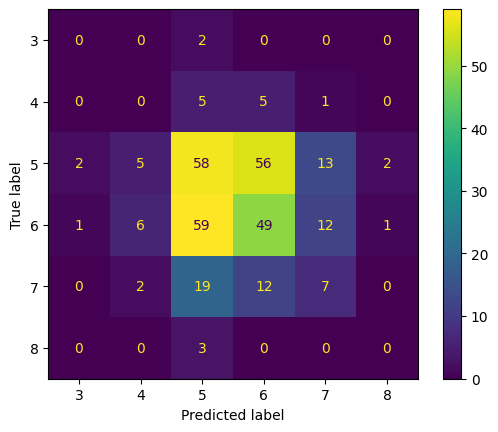

In [16]:
ConfusionMatrixDisplay.from_predictions(red_y_test, red_dummy_pred)

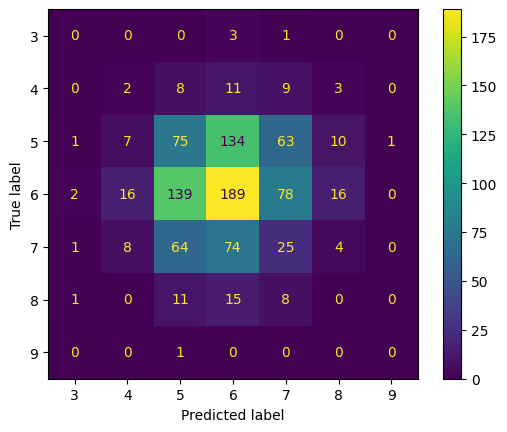

In [17]:
ConfusionMatrixDisplay.from_predictions(white_y_test, white_dummy_pred)

This is to be expected. The model does an okay job predicting the majority classes, but completely fails to classify minority classes.

In [18]:
# red wine metrics
red_dummy_prec, red_dummy_rec, red_dummy_f, _ = precision_recall_fscore_support(
    red_y_test, red_dummy_pred,
    beta=1.0,
    average='weighted'
)

# white wine metrics
white_dummy_prec, white_dummy_rec, white_dummy_f, _ = precision_recall_fscore_support(
    white_y_test, white_dummy_pred,
    beta=1.0,
    average='weighted'
)

print(
    f"Red Precision: {red_dummy_prec} \n"
    f"Red Recall: {red_dummy_rec} \n"
    f"Red F1 Score: {red_dummy_f} \n"
    f"White Precision: {white_dummy_prec} \n"
    f"White Recall: {white_dummy_rec} \n"
    f"White F1 Score: {white_dummy_f}"
)

Red Precision: 0.35600650565842573 
Red Recall: 0.35625 
Red F1 Score: 0.355595297775187 
White Precision: 0.30036996542597116 
White Recall: 0.2969387755102041 
White F1 Score: 0.29858013310184683


Good! Notice that the DummyClassifier's accuracy score is equal to the weighted recall.

The F1-score is slightly more preferable, as we want to penalize the model's accuracy for incorrect classifications.

Now we have our baseline scores to beat:
- Red Wine Baseline: 35.56%
- White Wine Baseline: 29.86%

### Model Selection

With our baseline settled, we have a variety of possible models, each with their own benefits and drawbacks. The most preferable algorithm will have:

1. Ability to recognize target variable as ordinal
2. Robust to outliers
3. Robust to multicollinearity
4. Ability to describe feature importance
5. Sensitive enough to detect anomalies
6. Can detect anomalies with very little data

There's no model (that I know of) that meets all of these criteria, but not all of these criteria are equally important.

These are a few of the models I'd like to try:

- Lasso Regression (ordinal target result, minimizes unimportant features, not so good at anomaly detection)
- Decision Tree Regression (ordinal target result, good for detecting classes, feature importance?)
- Decision Tree Classification (class detection, anomaly detection?)
- k-Nearest neighbors ("groups" points, may help with anomaly detection)
- Support Vector Machine (lots of possibilities here, but we'll stick to a one-to-rest approach to keep things simple for the first iteration of modeling)
- Stochastic Gradient Boosting (can be trained to be more "aware" of anomalies)

Note that we'll be using these basic models "out of the box" - we won't be tuning any hyperparameters.

In [19]:
# Lasso Regression models
red_lr = Lasso()
white_lr = Lasso()

# fit models
red_lr.fit(red_X_train, red_y_train)
white_lr.fit(white_X_train, white_y_train)

# get predictions
red_lr_pred = red_lr.predict(red_X_test).astype(int)
white_lr_pred = white_lr.predict(white_X_test).astype(int)

For our metrics, let's contain them in functions so we can reuse them.

In [20]:
# confusion matrix
def confmat_display(color, predictions):
    if color == 'red':
        return ConfusionMatrixDisplay.from_predictions(red_y_test, predictions)
    elif color == 'white':
        return ConfusionMatrixDisplay.from_predictions(white_y_test, predictions)

# precision, recall, and F1-scores
def mod_scores(color, predictions):
    # red wine metrics
    if color == 'red':
        red_prec, red_rec, red_f, _ = precision_recall_fscore_support(
            red_y_test, predictions,
            beta=1.0,
            average='weighted',
            zero_division=0
        )
        print(
            f"Red Precision: {red_prec} \n"
            f"Red Recall: {red_rec} \n"
            f"Red F1 Score: {red_f}"
        )
    
    # white wine metrics
    if color == 'white':
        white_prec, white_rec, white_f, _ = precision_recall_fscore_support(
            white_y_test, predictions,
            beta=1.0,
            average='weighted',
            zero_division=0
        )
        print(
            f"White Precision: {white_prec} \n"
            f"White Recall: {white_rec} \n"
            f"White F1 Score: {white_f}"
        )

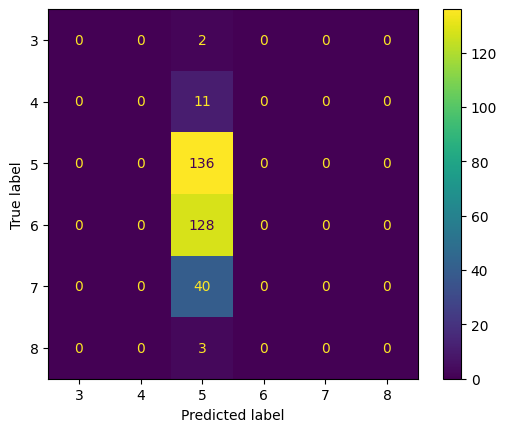

In [21]:
confmat_display('red', red_lr_pred)

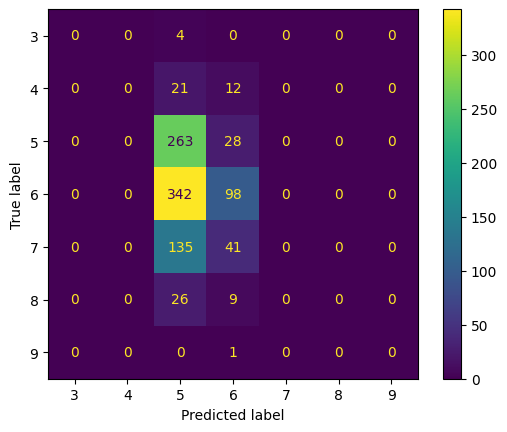

In [22]:
confmat_display('white', white_lr_pred)

In [23]:
mod_scores('red', red_lr_pred)
mod_scores('white', white_lr_pred)

Red Precision: 0.18062499999999998 
Red Recall: 0.425 
Red F1 Score: 0.2535087719298245
White Precision: 0.3315335601862602 
White Recall: 0.3683673469387755 
White F1 Score: 0.2842574717852371


Even worse than the dummy classifier! We are casting our predictions to an integer (from a continuous value) but it's still much worse, mostly because we aren't getting any predictions outside of 5 or 6. Let's try some models more suited to anomaly detection.

In [27]:
# Decision Tree Regressor models
red_dtr = DecisionTreeRegressor(random_state=42)
white_dtr = DecisionTreeRegressor(random_state=42)

# fit models
red_dtr.fit(red_X_train, red_y_train)
white_dtr.fit(white_X_train, white_y_train)

# get predictions
red_dtr_pred = red_dtr.predict(red_X_test).astype(int)
white_dtr_pred = white_dtr.predict(white_X_test).astype(int)

Red Precision: 0.6551408747449371 
Red Recall: 0.65 
Red F1 Score: 0.649419848991543
White Precision: 0.5821161545364795 
White Recall: 0.5816326530612245 
White F1 Score: 0.5807490061677082


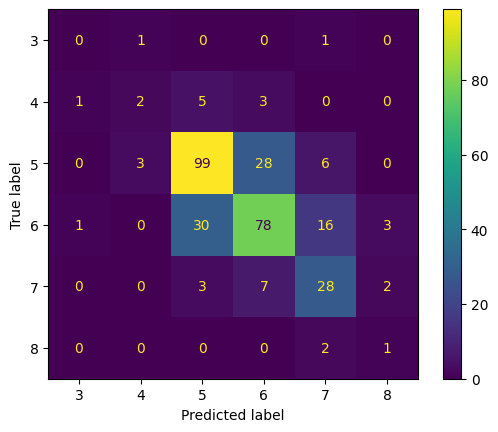

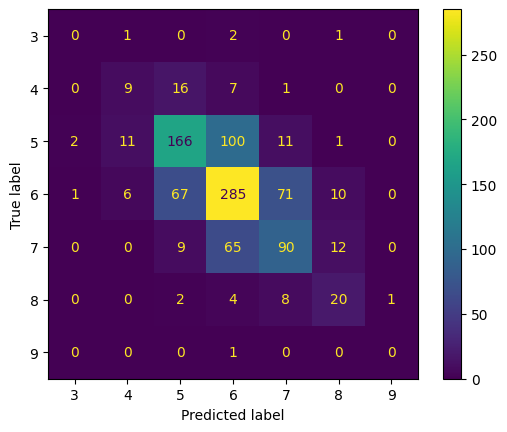

In [28]:
# confusion matrix and scores
confmat_display('red', red_dtr_pred)
confmat_display('white', white_dtr_pred)
mod_scores('red', red_dtr_pred)
mod_scores('white', white_dtr_pred)

A much better result. Our scores are better, and the DTR models are much better at capturing the ordinal nature of the target.

In [29]:
# Decision Tree Classifier models
red_dtc = DecisionTreeClassifier(random_state=42)
white_dtc = DecisionTreeClassifier(random_state=42)

# fit models
red_dtc.fit(red_X_train, red_y_train)
white_dtc.fit(white_X_train, white_y_train)

# get predictions
red_dtc_pred = red_dtc.predict(red_X_test)
white_dtc_pred = white_dtc.predict(white_X_test)

Red Precision: 0.6096878158606848 
Red Recall: 0.60625 
Red F1 Score: 0.6065716772993088
White Precision: 0.5926767628343899 
White Recall: 0.5908163265306122 
White F1 Score: 0.5913508279140259


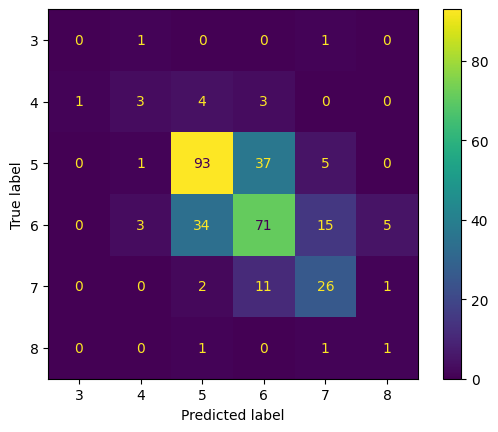

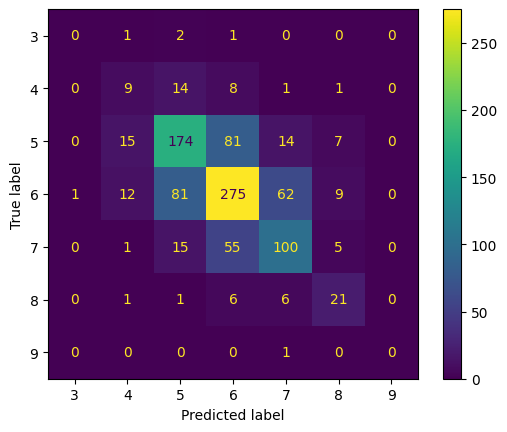

In [30]:
# confusion matrix and scores
confmat_display('red', red_dtc_pred)
confmat_display('white', white_dtc_pred)
mod_scores('red', red_dtc_pred)
mod_scores('white', white_dtc_pred)

The DTC models fail to capture the ordinal nature of the target, but they still provide about the same level of accuracy. 

In [31]:
# Nearest Neighbors Classifier models
red_knnc = KNeighborsClassifier()
white_knnc = KNeighborsClassifier()

# fit models
red_knnc.fit(red_X_train, red_y_train)
white_knnc.fit(white_X_train, white_y_train)

# get predictions
red_knnc_pred = red_knnc.predict(red_X_test)
white_knnc_pred = white_knnc.predict(white_X_test)

Red Precision: 0.4438099276345545 
Red Recall: 0.484375 
Red F1 Score: 0.45911032351872044
White Precision: 0.4311193700677281 
White Recall: 0.4448979591836735 
White F1 Score: 0.4332323529799542


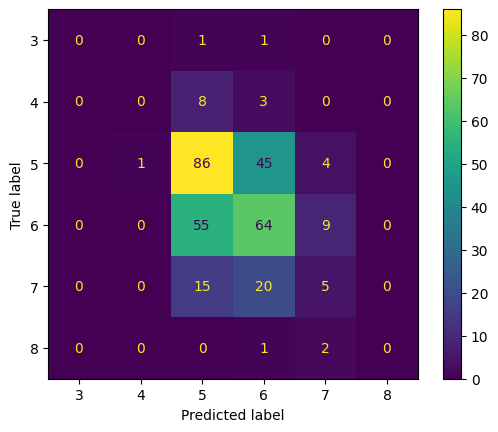

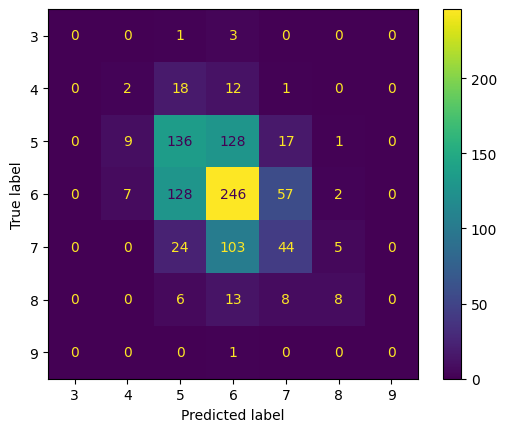

In [32]:
# confusion matrix and scores
confmat_display('red', red_knnc_pred)
confmat_display('white', white_knnc_pred)
mod_scores('red', red_knnc_pred)
mod_scores('white', white_knnc_pred)

Our scores are suffering compared to the Decision Tree algorithms.

In [40]:
%%capture
# Suppresses ConvergenceWarning errors

# SVM Classifier models
red_svc = LinearSVC(random_state=42)
white_svc = LinearSVC(random_state=42)

# fit models
red_svc.fit(red_X_train, red_y_train)
white_svc.fit(white_X_train, white_y_train)

# get predictions
red_svc_pred = red_svc.predict(red_X_test)
white_svc_pred = white_svc.predict(white_X_test)

We're getting a (suppressed) warning from this cell: `ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.` We won't worry too much about this for now.

Red Precision: 0.47540772532188835 
Red Recall: 0.51875 
Red F1 Score: 0.46241210313232467
White Precision: 0.2705762304921969 
White Recall: 0.061224489795918366 
White F1 Score: 0.0522853986955607


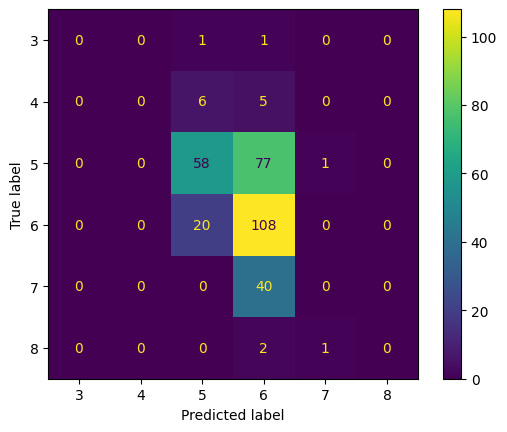

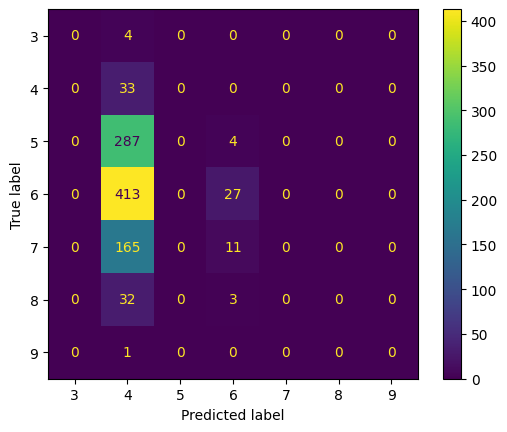

In [41]:
# confusion matrix and scores
confmat_display('red', red_svc_pred)
confmat_display('white', white_svc_pred)
mod_scores('red', red_svc_pred)
mod_scores('white', white_svc_pred)

This probably isn't the best representation of the SVC's power, since our model 'failed to converge'.

In [45]:
# Gradient Boosting Classifier models
red_gbc = GradientBoostingClassifier(random_state=42)
white_gbc = GradientBoostingClassifier(random_state=42)

# fit models
red_gbc.fit(red_X_train, red_y_train)
white_gbc.fit(white_X_train, white_y_train)

# get predictions
red_gbc_pred = red_gbc.predict(red_X_test)
white_gbc_pred = white_gbc.predict(white_X_test)

Red Precision: 0.6361986059904204 
Red Recall: 0.65 
Red F1 Score: 0.6414102913827298
White Precision: 0.5773067192408882 
White Recall: 0.5714285714285714 
White F1 Score: 0.5606229190337232


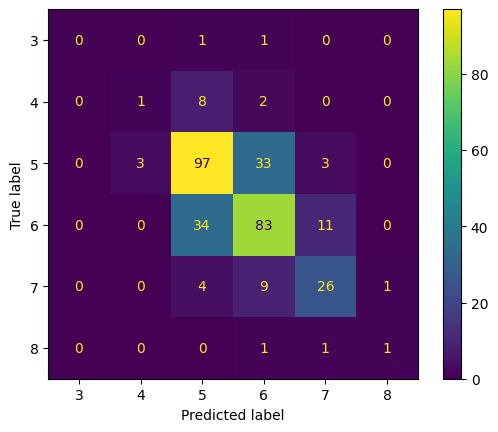

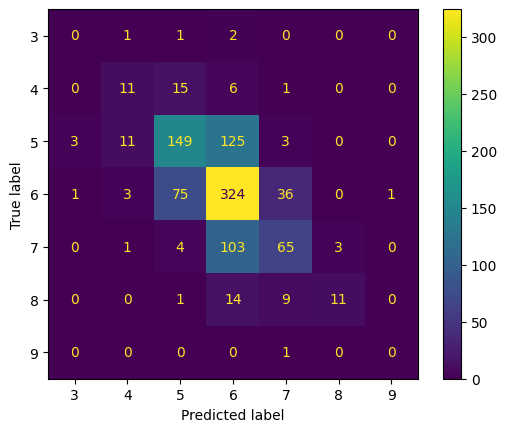

In [46]:
# confusion matrix and scores
confmat_display('red', red_gbc_pred)
confmat_display('white', white_gbc_pred)
mod_scores('red', red_gbc_pred)
mod_scores('white', white_gbc_pred)

For the "out of the box" models, Decision Tree Regressor performed the best! This is not a perfect representation of the other models, but it's a good start and puts us on the right track for reducing the possibilities of how to approach this problem.

## Second Iteration Summary & Insights


### Summary

In the second iteration, we:
- Made no alterations to our data
- Separated training and testing sets by stratifying the random sampling based on target
- Gathered predictions from a baseline (dummy) model and measured their performance by Confusion Matrix, precision, recall, & F1-score
- Fit our unaltered data to a variety of untuned models (Lasso, Decision Tree Regressor & Classifier, K Nearest Neighbors Classifier, Linear SVM Classifier, Gradient Boosting Classifier) and measured their predictions against the above-mentioned performance metrics.

### Insights

Our "out of the box" models aren't great, but they have shed some more light on how to approach this problem.

1. We should scale our data. With our starting models, we threw what we had into the models and watched what came out. The problem is that all of these models are sensitive to mismatched feature scales (which is exacerbated by the outliers). We'll need to scale our data, preferably with a scaling method that is robust to outliers.
2. Our models should benefit from the fact that our target is ordinal. Generally, an unordered categorical target adds complexity to the model, and this is not a complexity we need to address. Let's stick to regression algorithms.
    - It is possible that our predictions may still benefit (even more than regression) from models which separate clusters of data within a higher-dimensional space, such as nearest-neighbors and SVM. Let's not discard usage of these models just yet.
3. Our EDA has not yet included an examination of the feature distributions of the anomaly classes. Let's compare those to our overall distributions and see if we can extract any notable differences between them.


## Third Iteration

### EDA

Let's get a refresher on our value counts by target. Then we'll compare the feature distributions for the anomaly classes to the overall feature distributions.

In [2]:
red_df = pd.read_csv('winequality-red.csv', delimiter=';')
white_df = pd.read_csv('winequality-white.csv', delimiter=';')

In [3]:
print(red_df['quality'].value_counts().sort_index())
print(white_df['quality'].value_counts().sort_index())

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: quality, dtype: int64


In [4]:
# graphs distributions of features for quality value vs overall
def graph_anom_dist(df, anom_val, wine_type=''):
    # prepare column names
    df_cols = df.columns
    # prepare df of anomaly observations by quality value
    anom_df = df.loc[df['quality']==anom_val]
    # prepare display
    fig, axs = plt.subplots(2, 12, figsize=(15, 3))

    # fills distributions
    for i in range(12):
        axs[1][i].hist(df[df_cols[i]], bins=40)
        low_lim, high_lim = axs[1][i].get_xlim()
        axs[0][i].hist(anom_df[df_cols[i]], bins=40)
        axs[0][i].set_xlim(low_lim, high_lim)
        axs[1][i].set_xlabel(df_cols[i])
    
    fig.suptitle(f'{wine_type} Wine Features, Quality {anom_val} vs Overall')

    return fig.tight_layout()

In [ ]:
# red wine anomaly distributions vs overall
for val in [3, 4, 7, 8]:
    graph_anom_dist(red_df, val, 'Red')

In [ ]:
# white wine anomaly distributions vs overall
for val in [3, 4, 8, 9]:
    graph_anom_dist(white_df, val, 'White')

Nothing jumps out as being an anomaly indicator for any of the features. They all seem to be somewhat sparse, but representative of the overall distributions. A dead end, but that just means we'll have to rely more on our machine learning models.

### Scaling

We'll have to employ a scaling method to make our data more readable to machine learning algorithms. This is less important for simple regression algorithms (like linear regression) or rule-based algorithms (like decision trees) but it will make all the difference when we're working with distance-based models (KNN, SVM), or those that use gradient descent.

Because we're working with data that is fraught with outliers, it only makes sense to use a scaling method that is robust to such outliers. For this reason, we will use the Scikit-learn RobustScaler, which scales according to quantile range (instead of using mean and standard deviation).

We don't want to apply scaling before we split our data into training and testing sets, as that would cause data leakage (training data gets to "see" information from the testing set).

Let's split our data into training and testing sets, then apply the scaling.

In [4]:
# feature matrix and target vectors for each dataset
red_X = red_df.drop(columns=['quality'])
red_y = red_df['quality']
white_X = white_df.drop(columns=['quality'])
white_y = white_df['quality']

# split into train and test sets
red_X_train, red_X_test, red_y_train, red_y_test = train_test_split(red_X, red_y,
                                                        train_size=0.8,
                                                        random_state=42,
                                                        stratify=red_y
                                                    )
white_X_train, white_X_test, white_y_train, white_y_test = train_test_split(white_X, white_y,
                                                                train_size=0.8,
                                                                random_state=42,
                                                                stratify=white_y
                                                            )

In [5]:
red_rbs = RobustScaler()
white_rbs = RobustScaler()

# scale training sets
red_X_train_scaled = red_rbs.fit_transform(red_X_train)
white_X_train_scaled = white_rbs.fit_transform(white_X_train)

# scale testing sets
red_X_test_scaled = red_rbs.transform(red_X_test)
white_X_test_scaled = white_rbs.transform(white_X_test)

In [6]:
pd.DataFrame(red_X_train_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,0.184768,0.033636,0.042055,0.490841,0.425444,0.141856,0.197159,-0.006703,-0.007448,0.229867,0.140279
std,0.770602,0.740459,0.590612,1.965281,2.427679,0.698237,0.793685,0.841883,0.797890,0.938739,0.666045
min,-1.500000,-1.666667,-0.787879,-1.857143,-3.238095,-0.866667,-0.785714,-3.036364,-3.000000,-1.315789,-1.125000
25%,-0.363636,-0.520833,-0.484848,-0.428571,-0.476190,-0.466667,-0.404762,-0.522727,-0.526316,-0.368421,-0.437500
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.636364,0.479167,0.515152,0.571429,0.523810,0.533333,0.595238,0.477273,0.473684,0.631579,0.562500
max,3.636364,4.416667,2.242424,18.857143,25.285714,3.600000,5.952381,3.154545,3.105263,7.263158,2.937500


Nice. Our data is scaled by quartiles. Let's do some modeling.

### Modeling

Now that our data is scaled, let's fit it to some models and see how they perform. Before we fit the models, let's retrieve our custom metrics functions from the second iteration.

In [7]:
# confusion matrix
def confmat_display(color, y_true, predictions):
        return ConfusionMatrixDisplay.from_predictions(y_true, predictions)

# precision, recall, and F1-scores
def mod_scores(color, y_true, predictions):
    precision, recall, f_score, _ = precision_recall_fscore_support(
        y_true, predictions,
        beta=1.0,
        average='weighted',
        zero_division=0
    )
    print(
        f"{color} Precision: {precision} \n"
        f"{color} Recall: {recall} \n"
        f"{color} F1 Score: {f_score}"
    )

#### Lasso

In [8]:
red_lasso = Lasso()
red_lasso.fit(red_X_train_scaled, red_y_train)
red_lasso_pred = red_lasso.predict(red_X_test_scaled).astype(int)

white_lasso = Lasso()
white_lasso.fit(white_X_train_scaled, white_y_train)
white_lasso_pred = white_lasso.predict(white_X_test_scaled).astype(int)

Red Precision: 0.18062499999999998 
Red Recall: 0.425 
Red F1 Score: 0.2535087719298245


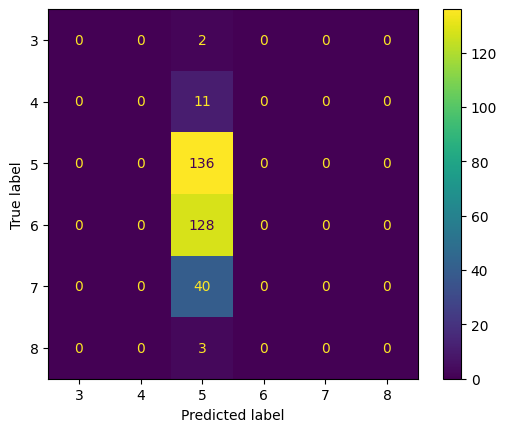

In [9]:
confmat_display('Red', red_y_test, red_lasso_pred)
mod_scores('Red', red_y_test, red_lasso_pred)

White Precision: 0.08817263640149937 
White Recall: 0.2969387755102041 
White F1 Score: 0.1359703913036497


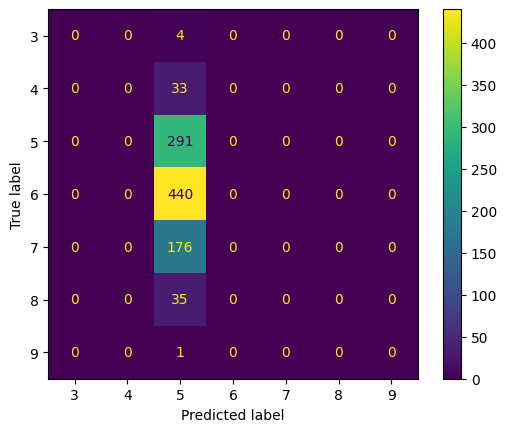

In [10]:
confmat_display('White', white_y_test, white_lasso_pred)
mod_scores('White', white_y_test, white_lasso_pred)

#### Decision Tree Regressor

In [11]:
red_dtr = DecisionTreeRegressor()
red_dtr.fit(red_X_train_scaled, red_y_train)
red_dtr_pred = red_dtr.predict(red_X_test_scaled).astype(int)

white_dtr = DecisionTreeRegressor()
white_dtr.fit(white_X_train_scaled, white_y_train)
white_dtr_pred = white_dtr.predict(white_X_test_scaled).astype(int)

Red Precision: 0.6668313189663266 
Red Recall: 0.65625 
Red F1 Score: 0.6590687675049454


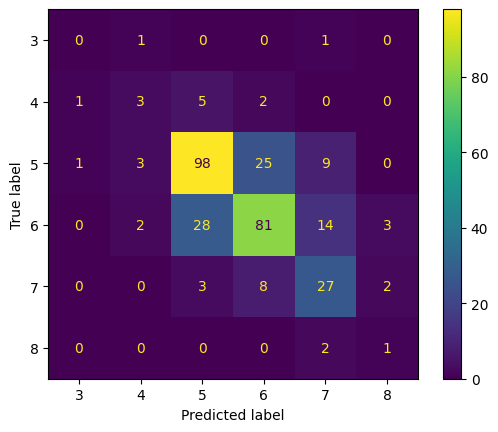

In [12]:
confmat_display('Red', red_y_test, red_dtr_pred)
mod_scores('Red', red_y_test, red_dtr_pred)

White Precision: 0.5883212747850332 
White Recall: 0.5897959183673469 
White F1 Score: 0.5877561145869589


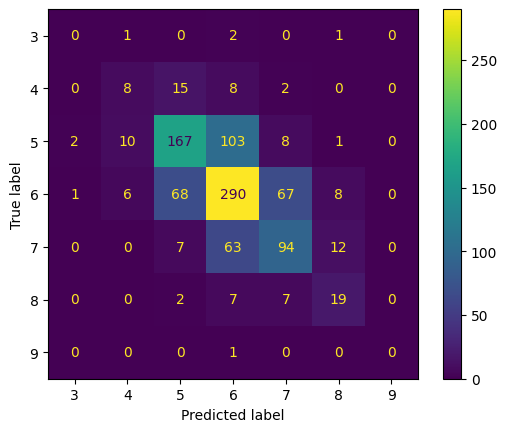

In [13]:
confmat_display('White', white_y_test, white_dtr_pred)
mod_scores('White', white_y_test, white_dtr_pred)

#### Decision Tree Classifier

In [14]:
red_dtc = DecisionTreeClassifier()
red_dtc.fit(red_X_train_scaled, red_y_train)
red_dtc_pred = red_dtc.predict(red_X_test_scaled)

white_dtc = DecisionTreeClassifier()
white_dtc.fit(white_X_train_scaled, white_y_train)
white_dtc_pred = white_dtc.predict(white_X_test_scaled)

Red Precision: 0.6075487764550265 
Red Recall: 0.609375 
Red F1 Score: 0.6080727710717027


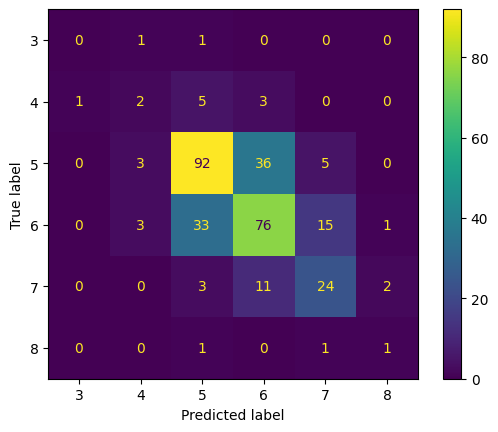

In [15]:
confmat_display('Red', red_y_test, red_dtc_pred)
mod_scores('Red', red_y_test, red_dtc_pred)

White Precision: 0.5959592095117995 
White Recall: 0.5908163265306122 
White F1 Score: 0.592517971050085


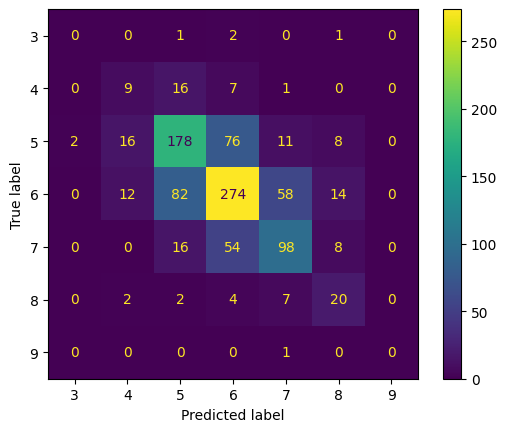

In [16]:
confmat_display('White', white_y_test, white_dtc_pred)
mod_scores('White', white_y_test, white_dtc_pred)

#### K Neighbors Classifier

In [17]:
red_knc = KNeighborsClassifier()
red_knc.fit(red_X_train_scaled, red_y_train)
red_knc_pred = red_knc.predict(red_X_test_scaled)

white_knc = KNeighborsClassifier()
white_knc.fit(white_X_train_scaled, white_y_train)
white_knc_pred = white_knc.predict(white_X_test_scaled)

Red Precision: 0.5757732259570495 
Red Recall: 0.5875 
Red F1 Score: 0.5759690712732306


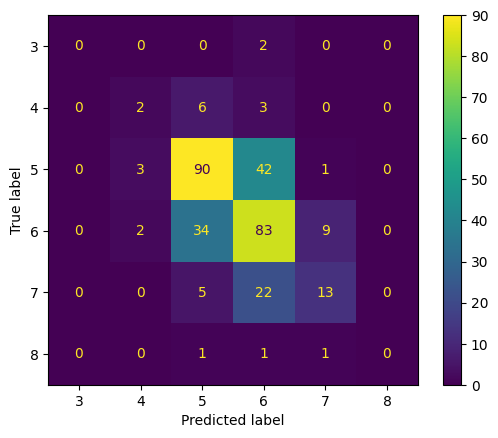

In [18]:
confmat_display('Red', red_y_test, red_knc_pred)
mod_scores('Red', red_y_test, red_knc_pred)

White Precision: 0.5179451235508118 
White Recall: 0.5265306122448979 
White F1 Score: 0.5202556690774433


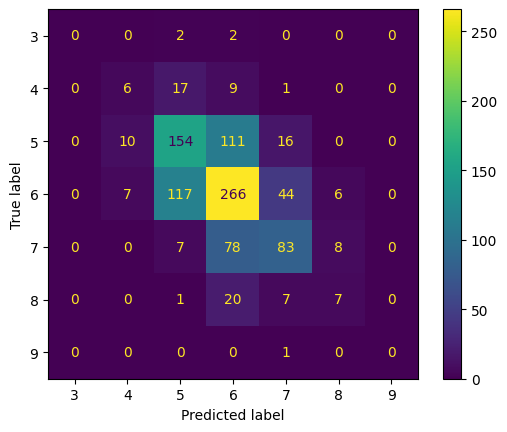

In [19]:
confmat_display('White', white_y_test, white_knc_pred)
mod_scores('White', white_y_test, white_knc_pred)

#### SVM Classifier

In [ ]:
red_lsvc = LinearSVC()
red_lsvc.fit(red_X_train_scaled, red_y_train)
red_lsvc_pred = red_lsvc.predict(red_X_test_scaled)

white_lsvc = LinearSVC()
white_lsvc.fit(white_X_train_scaled, white_y_train)
white_lsvc_pred = white_lsvc.predict(white_X_test_scaled)

Red Precision: 0.46790540540540543 
Red Recall: 0.565625 
Red F1 Score: 0.5119565217391304


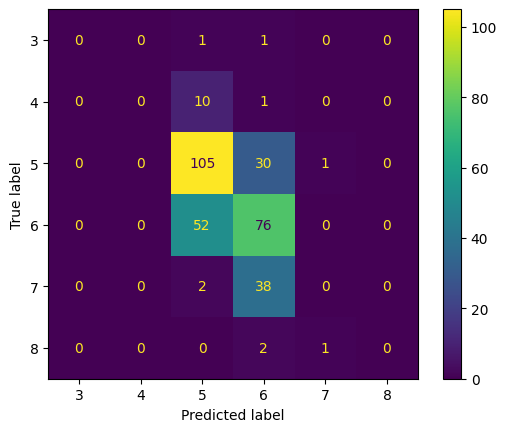

In [21]:
confmat_display('Red', red_y_test, red_lsvc_pred)
mod_scores('Red', red_y_test, red_lsvc_pred)

White Precision: 0.4834241236629488 
White Recall: 0.5275510204081633 
White F1 Score: 0.4700689268447625


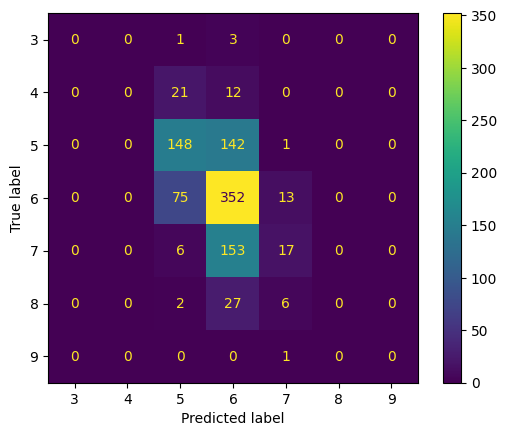

In [22]:
confmat_display('White', white_y_test, white_lsvc_pred)
mod_scores('White', white_y_test, white_lsvc_pred)

Again, the decision trees did quite well, but the rest of the models fared poorly in comparison. It's probably time for another iteration.

## Third Iteration Summary & Insights


### Summary

In the second iteration, we:
- Viewed distributions by anomaly value to see if any features were anomalous
- Separated training and testing sets
- Scaled our data by quartiles using RobustScaler
- Fit our unaltered data to a variety of untuned models (Lasso, Decision Tree Regressor & Classifier, K Nearest Neighbors Classifier, Linear SVM Classifier, Gradient Boosting Classifier) and measured their predictions against the above-mentioned performance metrics.

### Insights

Again, the "out of the box models" haven't done well, even with scaled features.

1. I still strongly believe in the regression approach, but perhaps immediately changing the regression value to an integer omits important data (a value of 7.84 is much more probable of being an 8 than a 7, even though the value is between them). We should view our unaltered regression predictions to see where they fall between each discrete value.
2. The UCI repository links to a research paper in which SVMs were recommended over other models. I should do more research on SVMs (an ML topic I know little about) and see what kinds of SVMs are available, and which might be beneficial to try on an anomalous dataset. Perhaps the linked paper is a good place to start.
3. Our decision tree models fared well in instances of scaling and not scaling. I like the idea of having a single tree, given that our anomalous values are so few. Perhaps a learning tree like XGBoost will prove more valuable. I am still undecided on regression or classification, so let's try both, but with classification, we will lean more heavily into the prediction probabilities. Perhaps we can weight these predictions, should the anomalous values consistently exceed a certain threshold.


## Fourth Iteration

Despite the progress from the first three iterations, their approach has been unfocused and unplanned. For the fourth iteration (and beyond) we will implement at least a basic set of goals.

1. Scale data (for use in non-rule-based models, like the SVMs)
2. Regression modeling using XGBoost regression, and SVR
3. Compare float regression values against true values
4. Classification modeling using XGBoost classification, and SVC
5. Compare classification probabilities against true values

In [2]:
# get dataframes
red_df = pd.read_csv('winequality-red.csv', delimiter=';')
white_df = pd.read_csv('winequality-white.csv', delimiter=';')

In [3]:
# split dataframes into training and testing sets

red_X = red_df.drop(columns=['quality'])
red_y = red_df['quality']
red_X_train, red_X_test, red_y_train, red_y_test = train_test_split(
    red_X, red_y,
    test_size=0.2,
    random_state=42,
    stratify=red_y
)

white_X = white_df.drop(columns=['quality'])
white_y = white_df['quality']
white_X_train, white_X_test, white_y_train, white_y_test = train_test_split(
    white_X, white_y,
    test_size=0.2,
    random_state=42,
    stratify=white_y
)

### Regression Models

In [5]:
# prepare boosted regressor for red wine data
red_xgbr = XGBRegressor(random_state=42, n_jobs=-1)
red_xgbr.fit(red_X_train, red_y_train)
red_xgbr_preds = red_xgbr.predict(red_X_test)

In [6]:
# prepare boosted regressor for white wine data
white_xgbr = XGBRegressor(random_state=42, n_jobs=-1)
white_xgbr.fit(white_X_train, white_y_train)
white_xgbr_preds = white_xgbr.predict(white_X_test)

In [9]:
# convert continuous regression values to integers
red_xgbr_preds_int = red_xgbr_preds.astype(int)
white_xgbr_preds_int = white_xgbr_preds.astype(int)

In [4]:
# confusion matrix
def confmat_display(y_true, predictions):
        return ConfusionMatrixDisplay.from_predictions(y_true, predictions)

# precision, recall, and F1-scores
def mod_scores(color, y_true, predictions):
    precision, recall, f_score, _ = precision_recall_fscore_support(
        y_true, predictions,
        beta=1.0,
        average='weighted',
        zero_division=0
    )
    print(
        f"{color} Precision: {precision} \n"
        f"{color} Recall: {recall} \n"
        f"{color} F1 Score: {f_score}"
    )

Red Precision: 0.5462422371032531 
Red Recall: 0.4875 
Red F1 Score: 0.48673288387365493


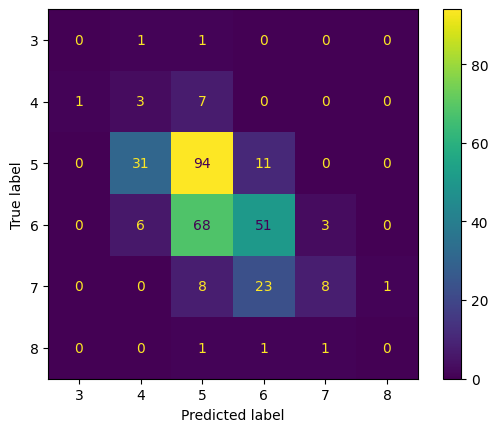

In [11]:
# red scores
confmat_display(red_y_test, red_xgbr_preds_int)
mod_scores('Red', red_y_test, red_xgbr_preds_int)

White Precision: 0.43880418762025764 
White Recall: 0.4530612244897959 
White F1 Score: 0.4172263531490048


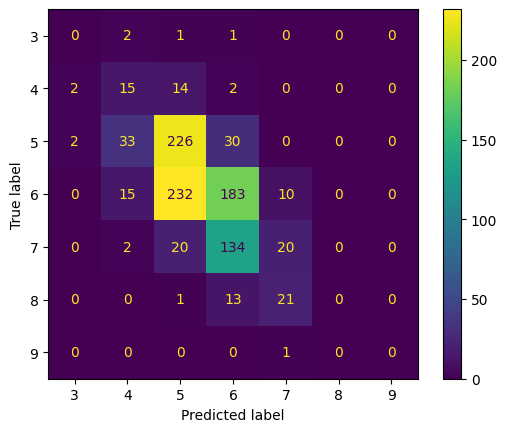

In [12]:
# white scores
confmat_display(white_y_test, white_xgbr_preds_int)
mod_scores('White', white_y_test, white_xgbr_preds_int)

Per the scikit-learn documentation, Support Vector Regression works in a similar way to SVClassification, except that the target vector is expected to have floating point values. It is unclear whether or not SVR will provide regression predictions when the target vector is integer values. Let's try it with red wine, and if it works, we will extend the process to white wine.

As per the (theoretical) value provided by quantile scaling, we will apply RobustScaler to our values.

In [4]:
red_scaler = RobustScaler()
red_X_train_scaled = red_scaler.fit_transform(red_X_train)

In previous iterations, we used LinearSVC, which computes a linear classification. This may be fine, but let's try the RBF kernel, which will allow our SVM to "curve" the boundaries. We will leave the other parameters to their default for now.

In [10]:
red_svr = SVR(kernel='rbf')
red_svr.fit(red_X_train_scaled, red_y_train)

red_X_test_scaled = red_scaler.transform(red_X_test)
red_svr_preds = red_svr.predict(red_X_test_scaled)

In [11]:
red_svr_preds_int = red_svr_preds.astype(int)

Red Precision: 0.5174033524729615 
Red Recall: 0.446875 
Red F1 Score: 0.40180542210524084


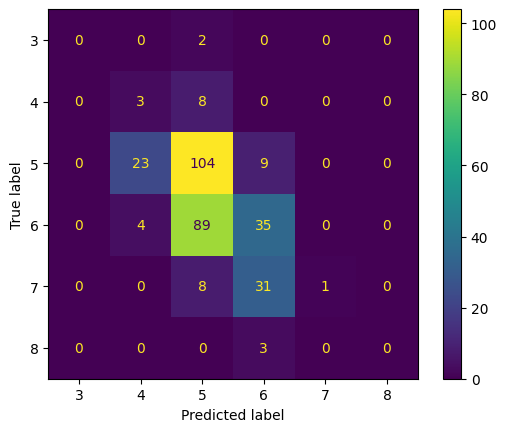

In [12]:
confmat_display(red_y_test, red_svr_preds_int)
mod_scores("Red", red_y_test, red_svr_preds_int)

At least the model works with non-regression target vectors. Let's do the same for white wine.

In [5]:
white_scaler = RobustScaler()
white_X_train_scaled = white_scaler.fit_transform(white_X_train)

In [14]:
white_svr = SVR(kernel='rbf')
white_svr.fit(white_X_train_scaled, white_y_train)

white_X_test_scaled = white_scaler.transform(white_X_test)
white_svr_preds = white_svr.predict(white_X_test_scaled)

In [15]:
white_svr_preds_int = white_svr_preds.astype(int)

White Precision: 0.459832130283728 
White Recall: 0.44081632653061226 
White F1 Score: 0.3923194960745981


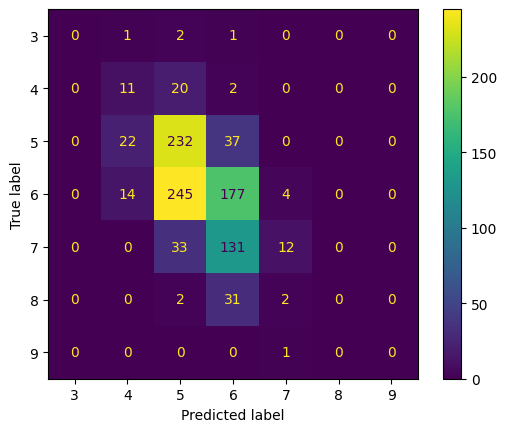

In [17]:
confmat_display(white_y_test, white_svr_preds_int)
mod_scores("White", white_y_test, white_svr_preds_int)

Both SVRs tend to accumulate values around the 5-6 range.

It's starting to become clear that despite the regression tasks understanding the ordinal nature of the target variable, they seem to "average" the probabilities of each test observation for each class.

If this is the case, then there's not much value in looking at how the prediction float values (from the regression models before they're converted to integers) would be useful, since we aren't able to extract how much weight each class' "prediction" has on the final float value. Let's do our classification models and look at the probabilities that a test observation belongs to each class. Perhaps if the probability of an anomalous classification exceeds a certain threshold, even if it's not the most probable class, it is a good indication that the value belongs to the anomalous class.

### Classifier Models

Classifiers need the available classes to range from [0, n] rather than [3, k]. Let's create a simple target vector transformer (and de-transformer) that satisfies the classifier's requirements.

In [5]:
def target_vector_class_transformer(target, base_class):
    return target - base_class

def target_vector_class_detransformer(target, base_class):
    return target + base_class

In [6]:
# prepare boosted classifer for red wine data
red_y_train_tf = target_vector_class_transformer(red_y_train, 3)
red_xgbc = XGBClassifier(random_state=42, n_jobs=-1)
red_xgbc.fit(red_X_train, red_y_train_tf)
red_xgbc_preds_ = red_xgbc.predict(red_X_test)
red_xgbc_preds = target_vector_class_detransformer(red_xgbc_preds_, 3)

In [7]:
# prepare boosted classifier for white wine data
white_y_train_tf = target_vector_class_transformer(white_y_train, 3)
white_xgbc = XGBClassifier(random_state=42, n_jobs=-1)
white_xgbc.fit(white_X_train, white_y_train_tf)
white_xgbc_preds_ = white_xgbc.predict(white_X_test)
white_xgbc_preds = target_vector_class_detransformer(white_xgbc_preds_, 3)

Red Precision: 0.6485361558731124 
Red Recall: 0.659375 
Red F1 Score: 0.6501012586537868


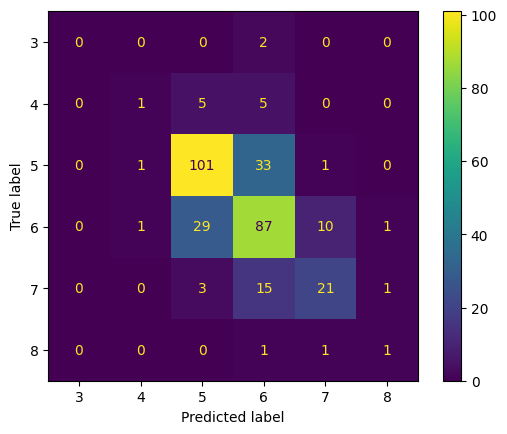

In [8]:
# red scores
confmat_display(red_y_test, red_xgbc_preds)
mod_scores('Red', red_y_test, red_xgbc_preds)

White Precision: 0.6523381945981928 
White Recall: 0.65 
White F1 Score: 0.6433398389588171


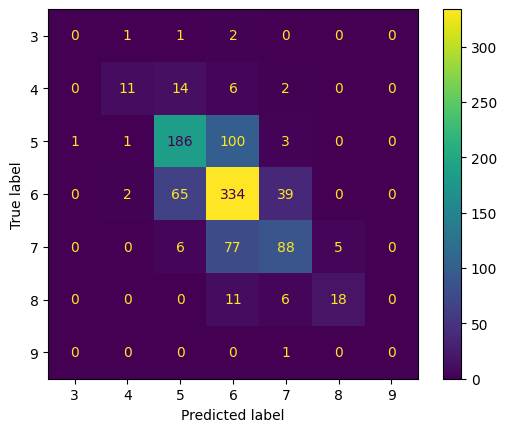

In [9]:
# white scores
confmat_display(white_y_test, white_xgbc_preds)
mod_scores('White', white_y_test, white_xgbc_preds)

In [8]:
# scale red data by quantiles
red_scaler = RobustScaler()
red_X_train_scaled = red_scaler.fit_transform(red_X_train)

In [9]:
# scale white data by quantiles
white_scaler = RobustScaler()
white_X_train_scaled = white_scaler.fit_transform(white_X_train)

In [21]:
# filter "feature names not used" warning from sklearn
import warnings
warnings.filterwarnings('ignore')

In [29]:
# prepare SVC for red wine data

# transform classes
red_y_train_tf = target_vector_class_transformer(red_y_train, 3)
# fit SVC
red_svc = SVC(kernel='rbf', random_state=42)
red_svc.fit(red_X_train_scaled, red_y_train_tf)
# scale test data
red_X_test_scaled = red_scaler.transform(red_X_test)
# transform predictions
red_svc_preds_ = red_svc.predict(red_X_test_scaled)
red_svc_preds = target_vector_class_detransformer(red_svc_preds_, 3)

In [30]:
# prepare SVC for white wine data

# transform classes
white_y_train_tf = target_vector_class_transformer(white_y_train, 3)
# fit SVC
white_svc = SVC(kernel='rbf', random_state=42)
white_svc.fit(white_X_train_scaled, white_y_train_tf)
# scale test data
white_X_test_scaled = white_scaler.transform(white_X_test)
# transform predictions
white_svc_preds_ = white_svc.predict(white_X_test_scaled)
white_svc_preds = target_vector_class_detransformer(white_svc_preds_, 3)

Red Precision: 0.5843148267008986 
Red Recall: 0.596875 
Red F1 Score: 0.5517121212121212


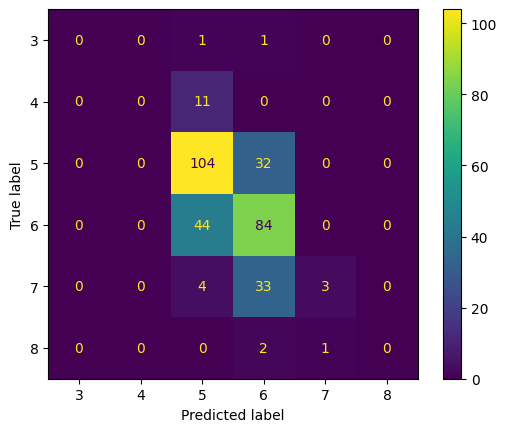

In [31]:
# red scores
confmat_display(red_y_test, red_svc_preds)
mod_scores('Red', red_y_test, red_svc_preds)

Red Precision: 0.5478095788012343 
Red Recall: 0.560204081632653 
Red F1 Score: 0.522606518330262


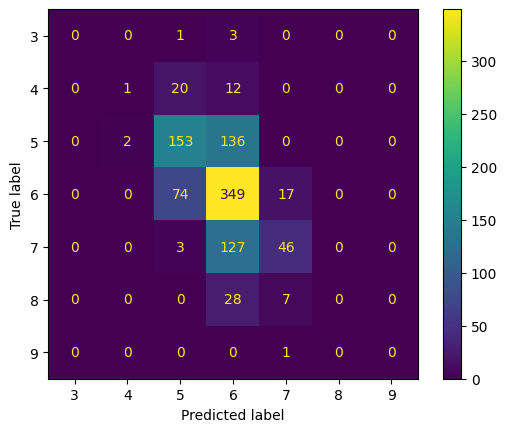

In [32]:
# red scores
confmat_display(white_y_test, white_svc_preds)
mod_scores('White', white_y_test, white_svc_preds)

In [33]:
# re-allow warnings
warnings.filterwarnings('default')

Our XGB classifier is looking promising, and the SVM classifier is looking less promising.

I'd like to see more about what's going on with our SVC, but per the scikit-learn documentation, predict_proba is inconsistent with predict due to the use of Platt's scaling. This essentially nullifies our use of class probabilities in the SVC to gain more insight about how the model classifies anomalous values.

The SVC appears to be biased towards the non-anomalous values. Perhaps it could benefit from adding class weights.

For the moment, let's take a look at class probabilities within the XGB Classifier and see if the model makes any meaningful connections.

In [8]:
red_probs = red_xgbc.predict_proba(red_X_test)
white_probs = white_xgbc.predict_proba(white_X_test)

In [9]:
red_probs

array([[2.8607232e-04, 6.3590996e-04, 4.4601165e-02, 5.1637697e-01,
        4.2763081e-01, 1.0469074e-02],
       [1.5795472e-03, 3.1597349e-03, 3.6338732e-01, 6.3146293e-01,
        2.3325912e-04, 1.7724109e-04],
       [1.1083673e-03, 2.0888720e-03, 9.1904157e-01, 7.7244252e-02,
        4.1571131e-04, 1.0119247e-04],
       ...,
       [5.7946458e-05, 6.5776570e-05, 1.0919366e-03, 9.9445629e-01,
        4.1939644e-03, 1.3403993e-04],
       [1.1152653e-03, 1.4013152e-02, 2.4824260e-01, 4.3106338e-01,
        2.9670116e-01, 8.8644857e-03],
       [3.2814143e-05, 1.8048933e-04, 9.9517918e-01, 4.5841518e-03,
        1.1360333e-05, 1.2055242e-05]], dtype=float32)

In [15]:
red_probs_df = pd.DataFrame(red_probs, columns=['3', '4', '5', '6', '7', '8'])
red_probs_df['target'] = red_y_test.values

In [16]:
white_probs_df = pd.DataFrame(white_probs, columns=['3', '4', '5', '6', '7', '8', '9'])
white_probs_df['target'] = white_y_test.values

In [17]:
red_probs_df.shape

(320, 7)

In [18]:
red_probs_df.head()

,3,4,5,6,7,8,target
0,0.000286,0.000636,0.044601,0.516377,0.427631,0.010469,6
1,0.001580,0.003160,0.363387,0.631463,0.000233,0.000177,5
2,0.001108,0.002089,0.919042,0.077244,0.000416,0.000101,5
3,0.000379,0.001348,0.014598,0.982953,0.000546,0.000177,5
4,0.000206,0.002378,0.875906,0.119866,0.001487,0.000157,6


In [23]:
red_probs_df['target'].value_counts()

5    136
6    128
7     40
4     11
8      3
3      2
Name: target, dtype: int64

In [21]:
red_probs_df.loc[red_probs_df['target']==8]

,3,4,5,6,7,8,target
9,0.000133,0.000212,0.022222,0.047010,0.012159,0.918264,8
88,0.000143,0.000458,0.024918,0.022598,0.930597,0.021288,8
186,0.003949,0.001480,0.033693,0.611279,0.347213,0.002386,8


In [22]:
red_probs_df.loc[red_probs_df['target']==3]

,3,4,5,6,7,8,target
144,0.000771,0.006491,0.073175,0.917151,0.002189,0.000224,3
221,0.000481,0.374898,0.024152,0.548586,0.051549,0.000334,3
